#### Update for v1.1
- v1.0 was valid to work
- v1.1 added doPrediction for predict whole CT scan as in test setting. 

# Configuration

In [1]:
MODEL_TO_LOAD = ''
FN_LOSS = 0
TRAINING_NAME = '3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2AutoWin'
TB_PREFIX = 'bonemeta_fn_{}'.format(FN_LOSS) + '_{}'.format(TRAINING_NAME)

WINDOWS = [(600,50), (1000,400)]
PATCH_SIZE = 128

# BATCH_SIZE = 120
BATCH_SIZE = 4
EPOCHS = 300

BASE_DIR = '/workspace/BoneMeta_all_128'
IMG_FOLDER_NAME = 'images'
LABEL_FOLDER_NAME = 'labels_lytic'
BONE_SEG_FOLDER_NAME = 'bone_seg'

In [2]:
import os
import sys
import hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk
import random

# Set dataset

In [3]:
IMG_DIR = os.path.join(BASE_DIR, IMG_FOLDER_NAME)
LABEL_DIR = os.path.join(BASE_DIR, LABEL_FOLDER_NAME)

IMG_FILES = os.listdir(IMG_DIR)
LABEL_FILES = os.listdir(LABEL_DIR)

def get_img_path(file): 
    return os.path.join(IMG_DIR, file)

def get_label_path(file):
    return os.path.join(LABEL_DIR, file)

def case_to_file(case):
    return case+'.npy'

def file_to_case(file_name):
    return file_name.split('.')[0]

set(IMG_FILES).issubset(LABEL_FILES)

True

In [4]:
print(IMG_DIR, len(IMG_FILES))
print(LABEL_DIR, len(LABEL_FILES))

/workspace/BoneMeta_all_128/images 310
/workspace/BoneMeta_all_128/labels_lytic 310


In [5]:
len(set(IMG_FILES)-set(LABEL_FILES))

0

In [6]:
# z축 작은 녀석들만 남기기 
SMALL_Z_CASES = ['000251_20190703_chest', '000356_20191024_chest', '000350_20190927_chest', '000397_20200214_chest', 'BH005_20170701_abdomen', 'BH041_20190201_C-T-L Spine (3D)', 'BH005_20170701_chest', '000355_20190901_abdomen', '000022_20180830_chest', '000244_20190501_abdomen', '000332_20191025_chest', '000019_20181018_chest', 'BH011_20190301_Spine^00_C_Spine_Pre_OP (Adult)', '000019_20190613_chest', 'BH017_20191201_abdomen', '000273_20190531_chest', '000404_20200305_chest', '000286_20190701_abdomen', 'SN015_20190901_chest', '000391_20200216_Thoracic Aorta CT Angio+3D (contrast)', '000262_20190501_abdomen', 'SN013_20190401_chest', '000285_20190807_chest', '000362_20191201_abdomen', '000322_20190913_chest', 'BH057_20191227_chest', '000400_20200210_chest', 'BH064_20200605_abdomen', 'BH034_20190901_chest', '000298_20190726_chest', '000311_20190902_chest', '000396_20200201_abdomen', '000223_20190319_chest', 'BH032_20180701_abdomen', '000291_20190701_abdomen', 'BH045_20181001_abdomen', '000296_20190726_chest', 'BH066_20190525_chest', 'BH010_20161101_chest', '000251_20190701_abdomen', 'SN007_20190701_chest', '000193_20190114_chest', '000262_20190529_chest', '000251_20190429_chest', 'BH060_20200413_chest', '000234_20190419_chest', 'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism) (2)', 'BH070_20160823_chest', '000316_20190627_chest', '000356_20190901_abdomen', '000383_20200121_chest', 'BH052_20190901_chest', '000450_20200512_chest', '000276_20190604_chest', '000364_20191217_chest', 'BH025_20191101_abdomen', 'BH035_20191101_GU Kidney & bladder CT (3D)', 'BH018_20190801_chest', '000269_20190601_abdomen', 'BH008_20190701_chest', '000332_20191001_abdomen', 'BH043_20191001_abdomen', '000260_20190522_chest', 'BH007_20190801_chest', 'BH067_20191017_chest', '000279_20190614_chest', 'SN004_20190901_chest', 'BH042_20180801_C-T-L Spine (3D)', 'BH099_20200806_abdomen', 'BH055_20200328_chest', 'BH001_20190401_chest', '000162_20180131_chest', 'BH054_20191122_abdomen', '000450_20200501_abdomen', 'BH030_20160101_T-L spine (3D)', '000372_20200107_chest', 'BH069_20200505_chest', 'BH012_20180401_abdomen', 'BH058_20180918_chest', '000404_20200201_abdomen', 'BH048_20190501_chest', '000348_20191201_CT Liver (contrast)', 'BH002_20190701_chest', '000376_20200101_abdomen', '000309_20190801_abdomen', 'SN017_20190701_chest', 'BH029_20200101_chest', 'BH059_20201013_abdomen', '000310_20190801_abdomen', '000272_20190614_chest', 'BH027_20191001_L-spine CT (3D)', 'BH064_20200605_chest', '000350_20191001_abdomen', '000232_20190423_chest', 'BH001_20190501_abdomen', 'BH039_20190601_chest', 'SN008_20190901_chest', '000270_20190608_chest', 'BH091_20200104_chest', '000269_20190604_chest', '000331_20190916_chest', '000325_20190919_chest', '000363_20191222_chest', '000260_20190501_CT Liver (contrast)', '000330_20190926_chest', 'BH072_20200219_abdomen', '000324_20190910_chest', 'BH009_20180301_chest', 'BH028_20190801_chest', 'SN029_20200301_chest', 'BH110_20200616_chest', '000401_20200201_T-Spine+3D CT (noncontrast)', 'SN031_20160501_chest', 'SN005_20191101_chest', '000452_20200513_chest', '000021_20181227_chest', '000236_20190401_abdomen', 'SN002_20190801_chest', '000382_20200129_chest', '000301_20190801_Pulmonary artery CT Angio+3D (contrast)', 'BH015_20190101_chest', 'BH043_20191001_chest', 'BH063_20200519_chest', '000363_20191201_abdomen', '000354_20191001_abdomen', 'BH047_20180901_abdomen', '000079_20180911_Pulmonary artery CT Angio+3D (contrast)', 'BH016_20151001_chest', 'BH061_20190315_abdomen', 'BH014_20181201_chest', '000362_20191214_chest', '000354_20191022_chest', 'SN051_20170401_chest', 'SN036_20190601_chest', 'BH017_20191201_chest', '000282_20190701_abdomen', 'BH023_20191101_chest', '000085_20180829_chest', 'SN019_20190801_chest', '000212_20190324_chest', '000302_20190726_chest', 'BH009_20180301_abdomen', 'BH008_20190701_abdomen', '000301_20190801_abdomen', 'BH015_20190101_abdomen', 'SN028_20160801_chest', '000344_20191125_chest', 'BH014_20181201_abdomen', '000214_20190325_chest', '000386_20200204_chest', '000372_20200101_abdomen', 'BH091_20200104_GU Kidney & bladder CT (3D)', 'SN025_20200401_chest', '000400_20200201_CT Biliary (contrast)', '000255_20190418_chest', 'BH081_20190322_abdomen', '000315_20190820_chest', '000288_20190701_abdomen', '000272_20190601_abdomen', '000322_20190901_abdomen', '000331_20190901_abdomen', 'SN055_20170301_chest', 'BH052_20190901_abdomen', '000310_20190812_chest', '000069_20180319_chest', 'BH024_20190501_abdomen', 'BH021_20181001_abdomen', '000009_20180417_chest', 'BH037_20171101_abdomen', '000002_20180829_chest', '000234_20190401_abdomen', '000262_20190318_chest', 'SN016_20190901_chest', '000232_20190401_abdomen', 'SN056_20170601_Thorax^01_Lung_Cancer_3D (Adult)', '000300_20190801_abdomen', 'BH006_20170801_chest', '000278_20190620_chest', 'BH036_20180301_GU Kidney & bladder CT (3D)', 'BH019_20191101_chest', 'BH004_20191101_chest', '000382_20200101_abdomen', '000242_20190409_chest', 'BH061_20190315_chest', '000080_20180911_chest', '000355_20191023_chest', '000364_20191201_abdomen', 'BH018_20190801_abdomen', '000291_20190718_chest', '000279_20190601_abdomen', '000308_20190826_chest', '000305_20190801_abdomen', 'BH010_20161101_abdomen', 'BH007_20190801_abdomen', 'BH021_20181001_chest', '000396_20200218_chest', '000091_20180504_chest', 'SN042_20170901_chest', '000314_20190827_chest', 'BH031_20160301_CT Angio + 3D Pulmonary artery (Embolism)', 'BH023_20191101_abdomen', '000301_20190827_chest', 'BH062_20201104_chest', 'BH020_20191201_chest', 'BH059_20201019_chest', '000246_20190629_chest', 'BH026_20190601_abdomen', 'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism)', 'BH034_20190901_abdomen', 'BH099_20200806_chest', 'BH051_20190301_GU Kidney & bladder CT (3D)', '000368_20200101_abdomen', 'BH057_20191227_abdomen', 'BH112_20190201_chest', 'BH024_20190501_chest', 'BH013_20191001_chest', '000309_20190823_chest', '000011_20181207_chest', 'BH020_20191201_abdomen', 'BH027_20191001_chest', '000316_20190715_Spine^L_SPINE (Adult)', '000012_20181214_chest', 'BH032_20180701_chest', 'BH037_20171101_chest', '000285_20190801_abdomen', 'BH038_20160901_CT angio + 3D C-spine(vertebral artery, C1-2)', 'BH072_20200219_chest', 'SN054_20170201_chest', '000048_20190501_abdomen', '000304_20190124_chest', 'BH045_20181001_chest', '000352_20191001_abdomen', 'BH016_20151001_abdomen', 'BH022_20190101_chest', 'BH047_20180901_chest', '000314_20190901_abdomen', 'BH065_20201013_chest', 'BH056_20200721_chest', '000281_20190701_chest', '000025_20180808_chest', '000352_20191017_chest', 'BH012_20180401_chest', '000224_20190228_chest', '000308_20190801_abdomen', '000376_20200114_chest']
SMALL_Z_FILES = [case_to_file(case) for case in SMALL_Z_CASES]
IMG_FILES = list(set(IMG_FILES).intersection(SMALL_Z_FILES))
len(IMG_FILES)

245

In [7]:
TRAIN_FILES = ['000019_20181018_chest.npy', '000019_20190601_abdomen.npy', '000019_20190613_chest.npy', '000021_20181227_chest.npy', '000022_20180830_chest.npy', '000025_20180808_abdomen.npy', '000025_20180808_chest.npy', '000080_20180911_chest.npy', '000085_20180829_chest.npy', '000091_20180504_chest.npy', '000162_20180131_chest.npy', '000193_20190114_chest.npy', '000214_20190325_chest.npy', '000223_20190319_chest.npy', '000224_20190228_chest.npy', '000234_20190401_abdomen.npy', '000234_20190419_chest.npy', '000236_20190401_abdomen.npy', '000242_20190409_chest.npy', '000244_20190501_abdomen.npy', '000246_20190629_chest.npy', '000251_20190429_abdomen.npy', '000251_20190429_chest.npy', '000251_20190701_abdomen.npy', '000251_20190703_chest.npy', '000255_20190418_chest.npy', '000262_20190318_chest.npy', '000262_20190319_abdomen.npy', '000262_20190501_abdomen.npy', '000262_20190529_chest.npy', '000269_20181016_abdomen.npy', '000269_20181214_abdomen.npy', '000269_20190325_abdomen.npy', '000269_20190601_abdomen.npy', '000269_20190604_chest.npy', '000270_20190601_abdomen.npy', '000270_20190608_chest.npy', '000276_20190604_chest.npy', '000279_20190601_abdomen.npy', '000279_20190614_chest.npy', '000280_20190625_CT Liver (contrast).npy', '000281_20190701_chest.npy', '000282_20190410_abdomen.npy', '000282_20190701_abdomen.npy', '000286_20190701_abdomen.npy', '000286_20190710_chest.npy', '000288_20190701_abdomen.npy', '000291_20190701_abdomen.npy', '000291_20190718_chest.npy', '000296_20190726_chest.npy', '000301_20190801_abdomen.npy', '000301_20190801_Pulmonary artery CT Angio+3D (contrast).npy', '000301_20190827_chest.npy', '000302_20190726_chest.npy', '000304_20190124_chest.npy', '000304_20190124_CT Liver (contrast).npy', '000308_20190801_abdomen.npy', '000308_20190826_chest.npy', '000309_20190801_abdomen.npy', '000309_20190823_chest.npy', '000311_20190902_chest.npy', '000314_20190827_chest.npy', '000314_20190901_abdomen.npy', '000315_20190820_chest.npy', '000315_20190901_abdomen.npy', '000322_20190901_abdomen.npy', '000322_20190913_chest.npy', '000324_20190910_chest.npy', '000325_20190919_chest.npy', '000330_20190926_chest.npy', '000331_20190901_abdomen.npy', '000331_20190916_chest.npy', '000332_20191001_abdomen.npy', '000332_20191025_chest.npy', '000344_20191125_chest.npy', '000352_20191001_abdomen.npy', '000352_20191017_chest.npy', '000354_20191001_abdomen.npy', '000354_20191022_chest.npy', '000355_20190901_abdomen.npy', '000355_20191023_chest.npy', '000356_20190901_abdomen.npy', '000356_20191024_chest.npy', '000362_20191201_abdomen.npy', '000362_20191214_chest.npy', '000363_20191201_abdomen.npy', '000363_20191222_chest.npy', '000364_20191201_abdomen.npy', '000364_20191217_chest.npy', '000368_20200101_abdomen.npy', '000372_20200101_abdomen.npy', '000372_20200107_chest.npy', '000376_20200101_abdomen.npy', '000376_20200114_chest.npy', '000382_20200101_abdomen.npy', '000382_20200129_chest.npy', '000386_20200204_chest.npy', '000396_20200201_abdomen.npy', '000396_20200218_chest.npy', '000404_20200201_abdomen.npy', '000404_20200305_chest.npy', 'BH004_20191101_chest.npy', 'BH008_20190701_abdomen.npy', 'BH008_20190701_chest.npy', 'BH009_20180301_abdomen.npy', 'BH009_20180301_chest.npy', 'BH010_20161101_abdomen.npy', 'BH010_20161101_chest.npy', 'BH011_20190301_Spine^00_C_Spine_Pre_OP (Adult).npy', 'BH012_20180401_abdomen.npy', 'BH012_20180401_chest.npy', 'BH013_20191001_chest.npy', 'BH014_20181201_abdomen.npy', 'BH014_20181201_chest.npy', 'BH015_20190101_abdomen.npy', 'BH015_20190101_chest.npy', 'BH016_20151001_abdomen.npy', 'BH016_20151001_chest.npy', 'BH017_20191201_abdomen.npy', 'BH017_20191201_chest.npy', 'BH018_20190801_abdomen.npy', 'BH018_20190801_chest.npy', 'BH019_20191101_chest.npy', 'BH020_20191201_abdomen.npy', 'BH020_20191201_chest.npy', 'BH021_20181001_abdomen.npy', 'BH021_20181001_chest.npy', 'BH022_20190101_chest.npy', 'BH023_20191101_abdomen.npy', 'BH023_20191101_chest.npy', 'BH024_20190501_abdomen.npy', 'BH024_20190501_chest.npy', 'BH025_20191101_abdomen.npy', 'BH026_20190601_abdomen.npy', 'BH028_20190801_chest.npy', 'BH029_20200101_chest.npy', 'BH030_20160101_T-L spine (3D).npy', 'BH031_20160301_CT Angio + 3D Pulmonary artery (Embolism).npy', 'BH032_20180701_abdomen.npy', 'BH032_20180701_chest.npy', 'BH034_20190901_abdomen.npy', 'BH034_20190901_chest.npy', 'BH035_20191101_GU Kidney & bladder CT (3D).npy', 'BH036_20180301_GU Kidney & bladder CT (3D).npy', 'BH037_20171101_abdomen.npy', 'BH037_20171101_chest.npy', 'BH038_20160901_CT angio + 3D C-spine(vertebral artery, C1-2).npy', 'BH042_20180801_C-T-L Spine (3D).npy', 'BH043_20191001_abdomen.npy', 'BH043_20191001_chest.npy', 'BH045_20181001_abdomen.npy', 'BH045_20181001_chest.npy', 'BH047_20180901_abdomen.npy', 'BH048_20190501_chest.npy', 'BH051_20190301_GU Kidney & bladder CT (3D).npy', 'BH052_20190901_abdomen.npy', 'BH052_20190901_chest.npy', 'BH054_20191122_abdomen.npy', 'BH055_20200328_chest.npy', 'BH056_20200721_chest.npy', 'BH057_20191227_abdomen.npy', 'BH057_20191227_chest.npy', 'BH058_20180918_chest.npy', 'BH059_20201013_abdomen.npy', 'BH059_20201019_chest.npy', 'BH064_20200605_abdomen.npy', 'BH064_20200605_chest.npy', 'BH066_20190525_chest.npy', 'BH067_20191017_chest.npy', 'BH069_20200505_chest.npy', 'BH081_20190322_abdomen.npy', 'BH112_20190201_chest.npy', 'SN001_20190901_abdomen.npy', 'SN002_20190801_abdomen.npy', 'SN002_20190801_chest.npy', 'SN005_20191001_abdomen.npy', 'SN005_20191101_chest.npy', 'SN007_20190701_chest.npy', 'SN007_20190801_abdomen.npy', 'SN008_20190901_chest.npy', 'SN009_20190801_abdomen.npy', 'SN009_20190801_chest.npy', 'SN010_20190801_CT Liver+Pelvis(contrast).npy', 'SN011_20180401_abdomen.npy', 'SN011_20180401_chest.npy', 'SN012_20150801_abdomen.npy', 'SN013_20190401_abdomen.npy', 'SN013_20190401_chest.npy', 'SN014_20190901_abdomen.npy', 'SN014_20190901_chest.npy', 'SN015_20190901_abdomen.npy', 'SN015_20190901_chest.npy', 'SN016_20190901_abdomen.npy', 'SN016_20190901_chest.npy', 'SN018_20190801_abdomen.npy', 'SN018_20190801_chest.npy', 'SN020_20190801_abdomen.npy', 'SN020_20190801_chest.npy', 'SN025_20200401_abdomen.npy', 'SN025_20200401_chest.npy', 'SN028_20160801_abdomen.npy', 'SN028_20160801_chest.npy', 'SN032_20190401_T spine CT pre contr.npy', 'SN032_20190501_abdomen.npy', 'SN036_20190601_chest.npy', 'SN039_20181001_abdomen.npy', 'SN039_20181001_chest.npy', 'SN040_20170201_abdomen.npy', 'SN040_20170201_CT Neck (contrast).npy', 'SN042_20170901_abdomen.npy', 'SN042_20170901_chest.npy', 'SN043_20170701_chest.npy', 'SN044_20160601_CT Liver+Pelvis(contrast).npy', 'SN045_20170201_abdomen.npy', 'SN045_20170201_chest.npy', 'SN051_20170401_abdomen.npy', 'SN051_20170401_chest.npy', 'SN054_20170201_chest.npy', 'SN055_20170301_abdomen.npy', 'SN055_20170301_chest.npy', '000383_20200121_chest.npy', '000450_20200501_abdomen.npy', '000450_20200512_chest.npy', '000452_20200513_chest.npy', 'BH047_20180901_chest.npy']
VAL_FILES = ['000316_20190627_chest.npy', '000316_20190715_Spine^L_SPINE (Adult).npy', 'SN034_20200101_abdomen.npy', 'SN034_20200101_chest.npy', 'SN059_20170501_chest.npy', 'BH027_20191001_L-spine CT (3D).npy', '000397_20200214_chest.npy', 'BH027_20191001_chest.npy', 'BH039_20190601_chest.npy', 'BH041_20190201_C-T-L Spine (3D).npy', 'BH060_20200413_chest.npy', 'BH062_20201104_chest.npy', 'SN035_20180101_chest.npy', 'SN048_20170801_chest.npy', '000232_20190401_abdomen.npy', '000232_20190423_chest.npy', '000285_20190801_abdomen.npy', '000285_20190807_chest.npy', '000348_20191201_CT Liver (contrast).npy', '000401_20200201_T-Spine+3D CT (noncontrast).npy', 'BH006_20170801_chest.npy', 'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism).npy', 'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism) (2).npy', 'BH065_20201013_chest.npy', 'BH099_20200806_abdomen.npy', 'BH099_20200806_chest.npy', 'BH110_20200616_chest.npy', 'SN004_20190801_abdomen.npy', 'SN004_20190901_chest.npy', 'SN017_20190701_chest.npy', 'SN017_20190801_abdomen.npy', 'SN029_20200301_abdomen.npy', 'SN029_20200301_chest.npy', 'SN030_20191101_abdomen.npy', 'SN049_20170901_abdomen.npy', 'SN049_20170901_chest.npy', 'SN050_20170401_chest.npy', 'SN056_20170601_Thorax^01_Lung_Cancer_3D (Adult).npy']
TEST_FILES = ['000009_20180417_chest.npy', '000079_20180911_Pulmonary artery CT Angio+3D (contrast).npy', '000212_20190324_chest.npy', 'BH001_20190501_abdomen.npy', '000048_20190501_abdomen.npy', '000069_20180319_chest.npy', '000278_20190620_chest.npy', 'SN046_20170601_abdomen.npy', 'BH005_20170701_chest.npy', '000002_20180829_chest.npy', '000005_20181202_abdomen.npy', '000010_20181214_abdomen.npy', '000011_20181207_abdomen.npy', '000011_20181207_chest.npy', '000012_20181212_abdomen.npy', '000012_20181214_chest.npy', '000260_20190501_CT Liver (contrast).npy', '000260_20190522_chest.npy', '000272_20190601_abdomen.npy', '000272_20190614_chest.npy', '000273_20190531_chest.npy', '000298_20190726_chest.npy', '000300_20190801_abdomen.npy', '000305_20190801_abdomen.npy', '000310_20190801_abdomen.npy', '000310_20190812_chest.npy', '000317_20190720_CT Liver (contrast).npy', '000350_20190927_chest.npy', '000350_20191001_abdomen.npy', '000391_20200216_Thoracic Aorta CT Angio+3D (contrast).npy', '000400_20200201_CT Biliary (contrast).npy', '000400_20200210_chest.npy', 'BH001_20190401_chest.npy', 'BH002_20190701_chest.npy', 'BH005_20170701_abdomen.npy', 'BH007_20190801_abdomen.npy', 'BH007_20190801_chest.npy', 'BH061_20190315_abdomen.npy', 'BH061_20190315_chest.npy', 'BH063_20200519_chest.npy', 'BH070_20160823_chest.npy', 'BH072_20200219_abdomen.npy', 'BH072_20200219_chest.npy', 'BH091_20200104_chest.npy', 'BH091_20200104_GU Kidney & bladder CT (3D).npy', 'SN019_20190801_abdomen.npy', 'SN019_20190801_chest.npy', 'SN031_20160501_abdomen.npy', 'SN031_20160501_chest.npy']

# EXCEPTIONS = ['BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism).npy', 'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism) (2).npy'] # 모델에서 data info 만들때 가끔 오류남.
EXCEPTIONS = []

TRAIN_FILES = list(set(TRAIN_FILES).intersection(set(IMG_FILES)) - set(EXCEPTIONS))
VAL_FILES = list(set(VAL_FILES).intersection(set(IMG_FILES)) - set(EXCEPTIONS))
TEST_FILES = list(set(TEST_FILES).intersection(set(IMG_FILES)) - set(EXCEPTIONS))

# TRAIN_FILES = TRAIN_FILES[:50]
# VAL_FILES = VAL_FILES[:15]

In [8]:
TRAIN_FILES = ['000376_20200101_abdomen.npy', '000400_20200210_chest.npy', 'BH018_20190801_abdomen.npy', 'BH062_20201104_chest.npy', '000262_20190501_abdomen.npy', 'BH007_20190801_abdomen.npy', 'BH072_20200219_chest.npy', '000251_20190701_abdomen.npy', '000368_20200101_abdomen.npy', 'BH007_20190801_chest.npy', '000224_20190228_chest.npy', 'BH066_20190525_chest.npy', 'SN054_20170201_chest.npy', '000246_20190629_chest.npy', 'SN031_20160501_chest.npy', 'SN051_20170401_chest.npy', '000272_20190614_chest.npy', '000396_20200218_chest.npy', '000305_20190801_abdomen.npy', '000450_20200501_abdomen.npy', 'BH018_20190801_chest.npy', '000404_20200305_chest.npy', 'BH020_20191201_chest.npy', 'BH008_20190701_chest.npy', 'BH021_20181001_abdomen.npy', '000352_20191017_chest.npy', 'SN036_20190601_chest.npy', 'BH045_20181001_chest.npy', '000348_20191201_CT Liver (contrast).npy', '000262_20190318_chest.npy', '000350_20190927_chest.npy', 'BH025_20191101_abdomen.npy', '000021_20181227_chest.npy', 'BH055_20200328_chest.npy', '000372_20200107_chest.npy', '000270_20190608_chest.npy', 'BH002_20190701_chest.npy', '000386_20200204_chest.npy', 'BH005_20170701_abdomen.npy', 'BH036_20180301_GU Kidney & bladder CT (3D).npy', '000331_20190916_chest.npy', 'BH013_20191001_chest.npy', '000009_20180417_chest.npy', '000291_20190718_chest.npy', '000316_20190715_Spine^L_SPINE (Adult).npy', 'BH027_20191001_chest.npy', '000302_20190726_chest.npy', '000304_20190124_chest.npy', 'BH008_20190701_abdomen.npy', '000272_20190601_abdomen.npy', 'BH043_20191001_chest.npy', 'BH043_20191001_abdomen.npy', 'BH061_20190315_chest.npy', '000396_20200201_abdomen.npy', '000019_20181018_chest.npy', '000316_20190627_chest.npy', '000311_20190902_chest.npy', '000332_20191001_abdomen.npy', 'BH037_20171101_abdomen.npy', 'BH024_20190501_abdomen.npy', '000356_20191024_chest.npy', '000331_20190901_abdomen.npy', '000091_20180504_chest.npy', '000286_20190701_abdomen.npy', 'SN055_20170301_chest.npy', 'SN005_20191101_chest.npy', 'BH070_20160823_chest.npy', '000330_20190926_chest.npy', 'BH061_20190315_abdomen.npy', 'BH024_20190501_chest.npy', 'BH032_20180701_abdomen.npy', 'SN056_20170601_Thorax^01_Lung_Cancer_3D (Adult).npy', '000309_20190801_abdomen.npy', 'BH005_20170701_chest.npy', '000285_20190807_chest.npy', '000363_20191222_chest.npy', '000080_20180911_chest.npy', '000291_20190701_abdomen.npy', 'SN007_20190701_chest.npy', '000332_20191025_chest.npy', 'BH064_20200605_chest.npy', 'BH026_20190601_abdomen.npy', 'SN015_20190901_chest.npy', '000079_20180911_Pulmonary artery CT Angio+3D (contrast).npy', '000285_20190801_abdomen.npy', 'BH023_20191101_chest.npy', '000011_20181207_chest.npy', '000242_20190409_chest.npy', 'BH004_20191101_chest.npy', '000269_20190604_chest.npy', 'SN017_20190701_chest.npy', 'BH063_20200519_chest.npy', 'BH064_20200605_abdomen.npy', 'BH016_20151001_chest.npy', 'BH051_20190301_GU Kidney & bladder CT (3D).npy', '000324_20190910_chest.npy', 'BH060_20200413_chest.npy', '000300_20190801_abdomen.npy', 'BH019_20191101_chest.npy', '000048_20190501_abdomen.npy', '000315_20190820_chest.npy', '000352_20191001_abdomen.npy', '000282_20190701_abdomen.npy', '000310_20190812_chest.npy', '000193_20190114_chest.npy', '000362_20191214_chest.npy', 'BH037_20171101_chest.npy', '000279_20190614_chest.npy', '000162_20180131_chest.npy', '000279_20190601_abdomen.npy', 'BH091_20200104_GU Kidney & bladder CT (3D).npy', '000262_20190529_chest.npy', '000450_20200512_chest.npy', '000251_20190429_chest.npy', 'BH072_20200219_abdomen.npy', '000022_20180830_chest.npy', 'BH006_20170801_chest.npy', 'BH021_20181001_chest.npy', '000296_20190726_chest.npy', '000309_20190823_chest.npy', 'BH039_20190601_chest.npy', 'BH023_20191101_abdomen.npy', 'BH010_20161101_abdomen.npy', '000012_20181214_chest.npy', 'BH065_20201013_chest.npy', 'BH045_20181001_abdomen.npy', 'BH054_20191122_abdomen.npy', '000382_20200129_chest.npy', '000310_20190801_abdomen.npy', '000019_20190613_chest.npy', 'BH056_20200721_chest.npy', '000382_20200101_abdomen.npy', 'BH020_20191201_abdomen.npy', 'BH031_20160301_CT Angio + 3D Pulmonary artery (Embolism).npy', '000269_20190601_abdomen.npy', '000404_20200201_abdomen.npy', 'SN013_20190401_chest.npy', '000344_20191125_chest.npy', 'BH110_20200616_chest.npy', '000356_20190901_abdomen.npy', 'BH016_20151001_abdomen.npy', 'BH091_20200104_chest.npy', '000251_20190703_chest.npy', '000363_20191201_abdomen.npy', '000376_20200114_chest.npy', '000350_20191001_abdomen.npy', '000212_20190324_chest.npy', '000278_20190620_chest.npy', '000362_20191201_abdomen.npy', '000372_20200101_abdomen.npy', 'BH032_20180701_chest.npy', 'BH010_20161101_chest.npy', 'BH035_20191101_GU Kidney & bladder CT (3D).npy', '000400_20200201_CT Biliary (contrast).npy', '000301_20190801_Pulmonary artery CT Angio+3D (contrast).npy', '000301_20190801_abdomen.npy', '000325_20190919_chest.npy', '000301_20190827_chest.npy', 'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism) (2).npy', '000273_20190531_chest.npy', 'SN029_20200301_chest.npy', 'BH069_20200505_chest.npy', 'SN002_20190801_chest.npy', '000391_20200216_Thoracic Aorta CT Angio+3D (contrast).npy']

VAL_FILES = ['000364_20191201_abdomen.npy', '000364_20191217_chest.npy', 'BH012_20180401_abdomen.npy', '000085_20180829_chest.npy', '000397_20200214_chest.npy', '000223_20190319_chest.npy', '000322_20190901_abdomen.npy', 'BH081_20190322_abdomen.npy', 'BH048_20190501_chest.npy', 'BH015_20190101_abdomen.npy', 'BH029_20200101_chest.npy', 'BH099_20200806_chest.npy', 'BH012_20180401_chest.npy', 'SN008_20190901_chest.npy', 'SN019_20190801_chest.npy', 'SN025_20200401_chest.npy', 'SN004_20190901_chest.npy', '000308_20190801_abdomen.npy', 'BH015_20190101_chest.npy', 'BH059_20201019_chest.npy', '000452_20200513_chest.npy', '000232_20190423_chest.npy', 'BH034_20190901_chest.npy', 'BH034_20190901_abdomen.npy', 'BH099_20200806_abdomen.npy', 'BH028_20190801_chest.npy', '000308_20190826_chest.npy', '000002_20180829_chest.npy', '000232_20190401_abdomen.npy', 'SN042_20170901_chest.npy', 'BH059_20201013_abdomen.npy', '000025_20180808_chest.npy', 'BH067_20191017_chest.npy', '000069_20180319_chest.npy', '000322_20190913_chest.npy']

TEST_FILES = ['000355_20190901_abdomen.npy', '000234_20190401_abdomen.npy', '000255_20190418_chest.npy', '000281_20190701_chest.npy', 'SN016_20190901_chest.npy', '000236_20190401_abdomen.npy', '000288_20190701_abdomen.npy', 'BH057_20191227_chest.npy', '000234_20190419_chest.npy', 'BH001_20190501_abdomen.npy', 'BH014_20181201_chest.npy', '000314_20190827_chest.npy', '000276_20190604_chest.npy', '000314_20190901_abdomen.npy', '000298_20190726_chest.npy', 'BH047_20180901_abdomen.npy', 'BH017_20191201_abdomen.npy', 'BH001_20190401_chest.npy', 'BH022_20190101_chest.npy', '000383_20200121_chest.npy', 'SN028_20160801_chest.npy', '000260_20190522_chest.npy', 'BH112_20190201_chest.npy', 'BH009_20180301_abdomen.npy', 'BH047_20180901_chest.npy', 'BH057_20191227_abdomen.npy', '000354_20191001_abdomen.npy', 'BH052_20190901_abdomen.npy', '000355_20191023_chest.npy', 'BH058_20180918_chest.npy', 'BH017_20191201_chest.npy', 'BH009_20180301_chest.npy', '000354_20191022_chest.npy', 'BH052_20190901_chest.npy', '000244_20190501_abdomen.npy', '000260_20190501_CT Liver (contrast).npy', 'BH014_20181201_abdomen.npy', '000214_20190325_chest.npy']

In [9]:
print(f'''
train: {len(TRAIN_FILES)}
val: {len(VAL_FILES)}
test: {len(TEST_FILES)}
total: {len(TRAIN_FILES + VAL_FILES + TEST_FILES)}
''')


train: 164
val: 35
test: 38
total: 237



In [10]:
def adjust_window(image, window):
    width = window[0]
    level = window[1]
    upper = level+width/2
    lower = level-width/2
    copied_image = image.clip(lower, upper)
    copied_image = copied_image-lower
    return (copied_image/(upper-lower))

### Select Lytic Lesions Only

In [11]:
data_info = pd.read_csv(os.path.join(BASE_DIR, 'data_info.csv'))
data_info.head()

,Case,Lesion Type,Lesion Location,I/V,File Name,Lesion Size,Background Size,Original Shape[x],Original Shape[y],Original Shape[z],...,Spine Original Center[z],x_spacing,y_spacing,z_spacing,Spine 1mm Resized Center[x],Spine 1mm Resized Center[y],Spine 1mm Resized Center[z],Spine 1mm Resized Shape[x],Spine 1mm Resized Shape[y],Spine 1mm Resized Shape[z]
0,000002_20180829_chest,M,T10,I,lesionAnnot3D-004,3449,104854151,512,512,400,...,266,0.736328,0.736328,1.0,40.734375,142.75,266,188.5,188.5,400
1,000005_20181202_abdomen,L,L5,V,lesionAnnot3D-001,34062,37976818,512,512,145,...,92,0.630859,0.630859,3.0,61.828125,107.25,276,161.5,161.5,435
2,000009_20180417_chest,S,C7-1,V,lesionAnnot3D-001,2299,89126661,512,512,340,...,8,0.738281,0.738281,1.0,46.343750,132.50,8,189.0,189.0,340
3,000009_20180417_chest,S,C7-2,I,lesionAnnot3D-002,872,89128088,512,512,340,...,19,0.738281,0.738281,1.0,57.343750,119.50,19,189.0,189.0,340
4,000009_20180417_chest,S,T1-2,I,lesionAnnot3D-004,1242,89127718,512,512,340,...,39,0.738281,0.738281,1.0,62.343750,124.50,39,189.0,189.0,340


In [12]:
lytic_index = data_info["Lesion Type"] == "L"
LYTIC_DATA_INFO = data_info.loc[lytic_index]
LYTIC_DATA_INFO.head(20)

,Case,Lesion Type,Lesion Location,I/V,File Name,Lesion Size,Background Size,Original Shape[x],Original Shape[y],Original Shape[z],...,Spine Original Center[z],x_spacing,y_spacing,z_spacing,Spine 1mm Resized Center[x],Spine 1mm Resized Center[y],Spine 1mm Resized Center[z],Spine 1mm Resized Shape[x],Spine 1mm Resized Shape[y],Spine 1mm Resized Shape[z]
1,000005_20181202_abdomen,L,L5,V,lesionAnnot3D-001,34062,37976818,512,512,145,...,92,0.630859,0.630859,3.0,61.828125,107.25,276,161.5,161.5,435
77,000019_20190601_abdomen,L,L5-1,V,lesionAnnot3D-017,326,38272698,512,512,146,...,96,0.619141,0.619141,3.0,33.171875,89.75,286,158.5,158.5,438
131,000025_20180808_abdomen,L,T8,V,lesionAnnot3D-001,226,40894238,512,512,156,...,4,0.722656,0.722656,3.0,47.468750,112.50,10,185.0,185.0,468
132,000025_20180808_abdomen,L,T9-2,I,lesionAnnot3D-003,296,40894168,512,512,156,...,14,0.722656,0.722656,3.0,49.468750,133.50,44,185.0,185.0,468
133,000025_20180808_abdomen,L,T10-2,V,lesionAnnot3D-005,112,40894352,512,512,156,...,20,0.722656,0.722656,3.0,54.468750,108.50,62,185.0,185.0,468
134,000025_20180808_abdomen,L,T10-3,I,lesionAnnot3D-006,84,40894380,512,512,156,...,19,0.722656,0.722656,3.0,37.468750,100.50,57,185.0,185.0,468
135,000025_20180808_abdomen,L,L1-1,V,lesionAnnot3D-011,1179,40893285,512,512,156,...,48,0.722656,0.722656,3.0,30.468750,116.50,142,185.0,185.0,468
136,000025_20180808_abdomen,L,L2-1,V,lesionAnnot3D-014,747,40893717,512,512,156,...,60,0.722656,0.722656,3.0,61.468750,108.50,178,185.0,185.0,468
137,000025_20180808_abdomen,L,L2-2,I,lesionAnnot3D-015,734,40893730,512,512,156,...,60,0.722656,0.722656,3.0,32.468750,79.50,178,185.0,185.0,468
138,000025_20180808_abdomen,L,L3,V,lesionAnnot3D-016,2205,40892259,512,512,156,...,72,0.722656,0.722656,3.0,32.468750,83.50,214,185.0,185.0,468


In [13]:
LYTIC_DATA_INFO['Lesion Volume'] = LYTIC_DATA_INFO['Lesion Size'] * LYTIC_DATA_INFO['x_spacing'] * LYTIC_DATA_INFO['y_spacing'] * LYTIC_DATA_INFO['z_spacing']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
LYTIC_DATA_INFO['Lesion Volume'].nsmallest(20)

1435    29.439926
1436    31.776428
1429    35.982132
1452    36.916733
1427    42.057037
1399    44.999724
1434    50.468445
1426    55.608749
2087    55.932181
1431    56.543350
2707    57.478563
2066    64.632742
1855    66.947937
1853    67.977905
2387    70.986175
2401    75.251032
1883    76.335953
970     79.179099
1998    79.498988
778     80.365643
Name: Lesion Volume, dtype: float64

In [15]:
using_index = LYTIC_DATA_INFO['Case'].isin([file_to_case(file) for file in IMG_FILES])
LYTIC_DATA_INFO = LYTIC_DATA_INFO.loc[using_index]

In [16]:
lytic_cases = list(LYTIC_DATA_INFO['Case'].unique())
len(lytic_cases)

115

In [17]:
len(LYTIC_DATA_INFO)

651

In [18]:
LYTIC_FILES = [case+'.npy' for case in lytic_cases]

TRAIN_FILES = list(set(TRAIN_FILES).intersection(set(LYTIC_FILES)))
VAL_FILES = list(set(VAL_FILES).intersection(set(LYTIC_FILES)))
TEST_FILES = list(set(TEST_FILES).intersection(set(LYTIC_FILES)))

In [19]:
print(f'''
train: {len(TRAIN_FILES)}
val: {len(VAL_FILES)}
test: {len(TEST_FILES)}
total: {len(TRAIN_FILES + VAL_FILES + TEST_FILES)}
''')


train: 71
val: 23
test: 21
total: 115



# Set dataloader

In [20]:
import time
import os, glob
import numpy as np
import pandas as pd
import torch 
from torch.utils.data import Dataset, DataLoader
from augmentation import get_transform

In [21]:
class TrainDataset(Dataset):
    def __init__(self, case_files=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.case_files = case_files
        self.images = [np.load(get_img_path(file)) for file in case_files]
        self.labels = [np.load(get_label_path(file)) for file in case_files]
        self.windows = WINDOWS
        self.multiplier = 1
        self.lesion_filter = {'min_vol': 500, 'max_vol':10000}
        filter_idx = (LYTIC_DATA_INFO['Lesion Volume'] > self.lesion_filter['min_vol']) & \
                     (LYTIC_DATA_INFO['Lesion Volume'] < self.lesion_filter['max_vol'])
        self.lytic_data_info = LYTIC_DATA_INFO.loc[filter_idx]
        
    def __len__(self):
        return len(self.case_files) * self.multiplier
    
    def __getitem__(self, idx):
        if idx % self.multiplier == 0:
            return self.get_case(idx // self.multiplier)            
        else:
            new_lesion_num = np.random.choice([1,2,3])
            lesion_list = self.get_random_lesions(new_lesion_num)
            case_idx = idx // self.multiplier
            return self.get_paste_case(lesion_list, case_idx)
    
    def get_random_lesions(self, lesion_num):
        total_lesion_number = len(self.lytic_data_info)
        selected_idxes = np.random.choice(range(total_lesion_number), lesion_num)
        selected_lesions = self.lytic_data_info.iloc[selected_idxes]
        
        lesion_list = []
        for i in range(lesion_num):
            lesion = selected_lesions.iloc[i,:]
            lesion_list.append((lesion['Case'], lesion['File Name']))
        return lesion_list
    
    def get_paste_case(self, lesion_list, idx):
        image, label = crop_and_paste(lesion_list, file_to_case(self.case_files[idx]))
        return self.process_patch(image, label)
        
    def get_case(self, idx):
        patch_image = self.images[idx]
        patch_label = self.labels[idx]
        return self.process_patch(patch_image, patch_label)

    def process_patch(self, patch_image, patch_label):
#         patch_image, patch_label = torch.tensor(patch_image, dtype=torch.float32), torch.tensor(patch_label, dtype=torch.bool)
#         return self.convert_to_multi_channel_img(patch_image, self.windows), patch_label
        augmentation_dict={'flip': True, 'scale':0.2, 'rotate':False,'offset': 0.1, 'noise': 0.1}
        transformed_image, transformed_label = get_transform(patch_image, patch_label, augmentation_dict)
        return self.convert_to_multi_channel_img(transformed_image, self.windows), transformed_label   
    
    def convert_to_multi_channel_img(self, image, windows):
        adjusted_images = [adjust_window(image, window) for window in windows]
        return torch.stack(adjusted_images)

In [22]:
import nibabel as nib
from monai.transforms import Resize

def crop_and_paste(lesion_list, target_case):
    """
    Copy a lesion from source case and paste it to target case.
    Return img(3D npy, dtype=int16) and label(3D npy, dtype=bool)
    lesion_list = [(source_case, lesion)]
    source_case = case_id: str
    lesion_id = lesion id: str, lesion_id + .nii.gz = lesion filename
    target_case = case_id: str
    """

    target_image = get_case_image(target_case)
    target_label = get_case_label(target_case)

    for lesion in lesion_list:
        source_case, lesion_id = lesion
        lesion_file = lesion_id + '.nii.gz'
        
        lesion_image = get_case_image(source_case)
        lesion_label = get_lesion_label(source_case, lesion_file)
        
        location = get_target_location(target_case, target_image)
        new_image = paste_source_to_target_image(lesion_image, lesion_label, target_image, location)
        new_label = paste_source_to_target_image(lesion_label, lesion_label, target_label, location)
        
        target_image = new_image
        target_label = new_label
    
    return target_image, target_label

def get_case_image(case_id):
    path = os.path.join(BASE_DIR, 'images', case_id + '.npy')
    return np.load(path)

def get_case_label(case_id):
    path = os.path.join(BASE_DIR, 'labels_lytic', case_id + '.npy')
    return np.load(path)

def get_lesion_label(case_id, lesion_file):
    path = os.path.join('/workspace/BoneMeta_raw/label', case_id, lesion_file)
    label_nii = nib.load(path)
    label_npy = np.transpose(label_nii.get_fdata(), (2,1,0)) > 0
    label_npy = label_npy[::-1] # label이 뒤집혀있음. 
    
    # for 128 dim
    resizer = Resize([128,128,128])
    resized_npy = resizer(label_npy[np.newaxis,:]) # with channel
    return resized_npy[0] > 0.5 # without channel

def get_target_location(case_id, target_image):
    bone_mask = get_bone_seg(case_id)
    high_density_mask = target_image > 600 # 이 부분이 sclerotic 에서는 문제가 될 수 있음. 
    loc_candidate = (bone_mask * high_density_mask).nonzero()
    random_index = np.random.choice(range(len(loc_candidate[0])))
    return (loc_candidate[0][random_index], loc_candidate[1][random_index], loc_candidate[2][random_index])

def get_bone_seg(case_id):
    path = os.path.join(BASE_DIR, 'bone_seg', case_id + '.npy')
    return np.load(path)

def paste_source_to_target_image(source_image, source_label, target_image, location):
    source_bbox = get_bbox_3D(source_label)
    cropped_source_image = crop_bbox(source_image, source_bbox)
    cropped_source_label = crop_bbox(source_label, source_bbox)
    
    cropped_shape =  cropped_source_image.shape
    padded_target_image = pad_for_half(target_image, cropped_shape)
    z_start = location[0]
    z_end = location[0] + cropped_shape[0]
    r_start = location[1]
    r_end = location[1] + cropped_shape[1]
    c_start = location[2] 
    c_end = location[2] + cropped_shape[2]
    
    padded_target_image[z_start:z_end, r_start:r_end, c_start:c_end] = \
    (cropped_source_image * cropped_source_label) + \
    (padded_target_image[z_start:z_end, r_start:r_end, c_start:c_end] * ~cropped_source_label)
    
    unpadded_target_image = padded_target_image[cropped_shape[0]//2:cropped_shape[0]//2 + source_image.shape[0], 
                                               cropped_shape[1]//2:cropped_shape[1]//2 + source_image.shape[1], 
                                               cropped_shape[2]//2:cropped_shape[2]//2 + source_image.shape[2]]
    return unpadded_target_image
    
def get_bbox_3D(label):

    z = np.any(label, axis=(1, 2))
    r = np.any(label, axis=(0, 2))
    c = np.any(label, axis=(0, 1))

    zmin, zmax = np.where(z)[0][[0, -1]]
    rmin, rmax = np.where(r)[0][[0, -1]]
    cmin, cmax = np.where(c)[0][[0, -1]]

    return zmin, zmax, rmin, rmax, cmin, cmax

def crop_bbox(npy, bbox):
    zmin, zmax, rmin, rmax, cmin, cmax = bbox
    return npy[zmin:zmax+1, rmin:rmax+1, cmin:cmax+1]

def pad_for_half(image, patch_size):
    patch_z, patch_r, patch_c = patch_size 
    padded_image = np.pad(image, [(patch_z//2, patch_z//2), (patch_r//2, patch_r//2), (patch_c//2, patch_c//2)])
    return padded_image 

In [23]:
class ValDataset(Dataset):
    def __init__(self, case_files=None, ):
        """
        Args:
            case_files (string): case filenames
        Return:
            one whole case

        """
        self.case_files = case_files
        self.images = [np.load(get_img_path(file)) for file in case_files]
        self.labels = [np.load(get_label_path(file)) for file in case_files]
        self.windows = WINDOWS

        
    def __len__(self):
        return len(self.case_files)
    
    def __getitem__(self, idx):
        image, label = self.images[idx], self.labels[idx]
        image_tensor = torch.tensor(image, dtype = torch.float32)
        multi_channel_image = self.convert_to_multi_channel_img(image_tensor, self.windows)
        return multi_channel_image, torch.tensor(label, dtype = torch.bool)
    
    def change_to_pytorch_coord(self, coord):
        # 현재 데이터 저장이 col, row, z 로 되어있음. -> z, row, col로 변경
        return [coord[2],coord[1],coord[0]]

    def convert_to_multi_channel_img(self, image, windows):
        adjusted_images = [adjust_window(image, window) for window in windows]
        return torch.stack(adjusted_images)

In [24]:
# len(train_dataset)

In [25]:
def slice_img(img, offset, end, interval):
  if end is None:
    end = len(img)
  else: 
    if end > len(img): 
      end = len(img)
    if end <= offset:
      end = offset + 1
  return img[offset:end:interval]

def show_numpy_img(np_img, offset=0, end=None, interval=5, title=''): 
  sliced_img = slice_img(np_img, offset, end, interval)

  figsize_per_img = 3
  num_col = 5
  num_row = int(np.ceil(sliced_img.shape[0] / num_col))
  # fig, axs = plt.subplots(num_row, num_col, figsize = (figsize_per_img*num_col, figsize_per_img*num_row))
  plt.figure(figsize=(figsize_per_img*num_col, figsize_per_img*num_row))
  for i, img in enumerate(sliced_img):
    if i >= num_col*num_row:
      continue
    # axs[i].imshow(img)
    plt.subplot(num_row, num_col, i+1)
    plt.imshow(img, 'gray')
    # plt.title()
  plt.suptitle(title)
  plt.tight_layout()
  plt.show()

#npy image 정보 보여주기 
def show_img_info(np_img):
  print('Shape:', np_img.shape)
  print('DType:', np_img.dtype)
  print('Max:', np_img.max())
  print('Min:', np_img.min())
  print(np_img)

def plot_img_and_label(np_img, label, interval = 5, offset = 0, end=None, figsize_per_image = 5):
  sliced_img = slice_img(np_img, offset, end, interval)
  sliced_label = slice_img(label, offset, end, interval)
  
  num_row = len(sliced_img)
  num_col = 2

  plt.figure(figsize=(figsize_per_image*num_col, figsize_per_image*num_row))

  for i in range(0, num_row):
    plt.subplot(num_row, num_col, i*num_col+1)
    tissue_image = sliced_img[i]
    plt.imshow(tissue_image, 'gray')

    plt.subplot(num_row, num_col, i*num_col+2)
    mask = sliced_label[i]
    label_on_tissue = sitk.LabelMapContourOverlay(sitk.Cast(sitk.GetImageFromArray(mask), sitk.sitkLabelUInt8), sitk.GetImageFromArray(tissue_image), opacity=0.7, contourThickness=[2,2], colormap=(0,255,0))
    plt.imshow(sitk.GetArrayFromImage(label_on_tissue), 'gray')

  plt.tight_layout()
  plt.show()

In [26]:
# img, label = train_dataset[0]
# plot_img_and_label(img[0].type(torch.int16).numpy(), label.type(torch.uint8).numpy())

# # plot_img_and_label(*train_dataset[0])

In [27]:
t = time.perf_counter()

train_dataset = TrainDataset(TRAIN_FILES)
val_dataset = ValDataset(VAL_FILES)

elapsed_time = time.perf_counter() - t

print(f'''
consumed_time: {elapsed_time}s
train: {len(train_dataset)}
val: {len(val_dataset)}
''')



consumed_time: 0.4026388190686703s
train: 71
val: 23



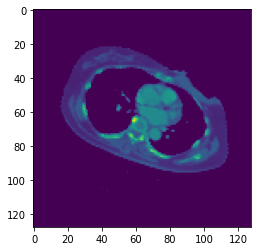

In [29]:
import matplotlib.pyplot as plt

sample_train = train_dataset[16]
plt.imshow(sample_train[0][1][PATCH_SIZE//2])

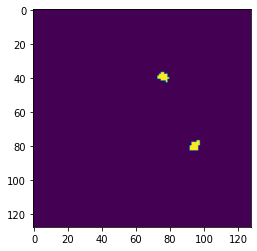

In [30]:
plt.imshow(sample_train[1][PATCH_SIZE//2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


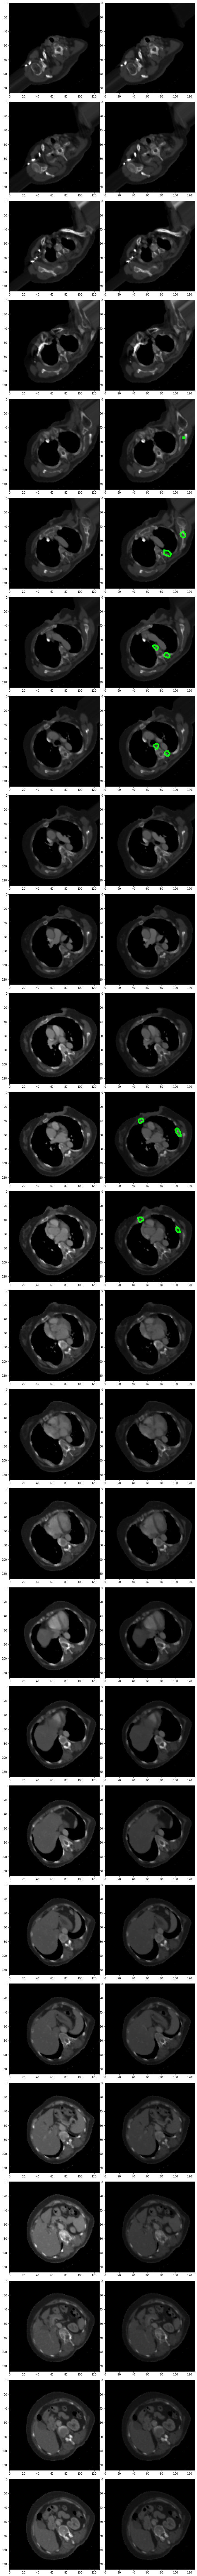

In [32]:
sample_train = train_dataset[16]
img = sample_train[0][1]
label = sample_train[1]

plot_img_and_label(img, label.type(torch.uint8))

# Dataloader 

In [33]:
import multiprocessing
multiprocessing.cpu_count()

48

In [34]:
from torch.utils.data import DataLoader

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
# NUM_WORKERS = multiprocessing.cpu_count()
NUM_WORKERS = 8

def initTrainDl(train_ds, batch_size = BATCH_SIZE):
    if USE_CUDA:
        batch_size *= torch.cuda.device_count()

    train_dl = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=NUM_WORKERS,
        pin_memory=USE_CUDA,
        shuffle=True,
        drop_last=False # to prevent gradient exploding
    )
    return train_dl

def initValDl(val_ds, batch_size = BATCH_SIZE):
    val_dl = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=NUM_WORKERS,
        pin_memory=USE_CUDA,
    )
    return val_dl

# Set for training

In [35]:
import logging
log = logging.getLogger("3DUnet")
# log.setLevel(logging.WARN)
# log.setLevel(logging.INFO)
log.setLevel(logging.DEBUG)

In [36]:
import datetime
# For logging 
trn_writer = None
val_writer = None
# TB_PREFIX = img_type + "_fn0"
time_str = datetime.datetime.now().strftime('%Y-%m-%d_%H.%M.%S')

In [37]:
# Used for computeClassificationLoss and logMetrics to index into metrics_t/metrics_a
# METRICS_LABEL_NDX = 0
METRICS_LOSS_NDX = 1
# METRICS_FN_LOSS_NDX = 2
# METRICS_ALL_LOSS_NDX = 3

# METRICS_PTP_NDX = 4
# METRICS_PFN_NDX = 5
# METRICS_MFP_NDX = 6
METRICS_TP_NDX = 7
METRICS_FN_NDX = 8
METRICS_FP_NDX = 9

METRICS_SIZE = 10

In [38]:
from torch.optim import SGD, AdamW, RMSprop
from torch import nn
from pytorch3dunet.unet3d.model import UNet3D, ResidualUNet3D

def initModel():    
    segmentation_model = ResidualUNet3D(in_channels=2, out_channels=1, num_groups=32, f_maps=32, final_sigmoid=True, testing=True, num_levels=5)

    # augmentation_model = SegmentationAugmentation(**self.augmentation_dict)

    if USE_CUDA:
        log.info("Using CUDA; {} devices.".format(torch.cuda.device_count()))
        if torch.cuda.device_count() > 1:
            segmentation_model = nn.DataParallel(segmentation_model, )
            # augmentation_model = nn.DataParallel(augmentation_model)
        segmentation_model = segmentation_model.to(DEVICE)
        # augmentation_model = augmentation_model.to(DEVICE)

    return segmentation_model #, augmentation_model

def initOptimizer():
    return AdamW(segmentation_model.parameters(), lr=0.0001, weight_decay=0.00001)
    # return SGD(segmentation_model.parameters(), lr=0.001, momentum=0.99)

segmentation_model = initModel()
optimizer = initOptimizer()

# Load model
if MODEL_TO_LOAD :
  model_folder = os.path.join(BASE_DIR, 'models')
  model_path = os.path.join(model_folder, MODEL_TO_LOAD)
  seg_dict = torch.load(model_path, map_location='cpu')
  if torch.cuda.device_count() > 1:
    segmentation_model.module.load_state_dict(seg_dict['model_state'])
  else:
    segmentation_model.load_state_dict(seg_dict['model_state'])
    

In [39]:
segmentation_model

DataParallel(
  (module): ResidualUNet3D(
    (encoders): ModuleList(
      (0): Encoder(
        (basic_module): ExtResNetBlock(
          (conv1): SingleConv(
            (groupnorm): GroupNorm(1, 2, eps=1e-05, affine=True)
            (conv): Conv3d(2, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
            (ReLU): ReLU(inplace=True)
          )
          (conv2): SingleConv(
            (groupnorm): GroupNorm(32, 32, eps=1e-05, affine=True)
            (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
            (ReLU): ReLU(inplace=True)
          )
          (conv3): SingleConv(
            (groupnorm): GroupNorm(32, 32, eps=1e-05, affine=True)
            (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          )
          (non_linearity): ReLU(inplace=True)
        )
      )
      (1): Encoder(
        (pooling): MaxPool3d(kernel_size=2, stride=2, paddin

In [40]:
# for name, param in segmentation_model.named_parameters():
#     print(name)

In [41]:
# ## 끝에만 학습하게 하고 나머지 변수는 얼려버리기
# for name, param in segmentation_model.named_parameters():
#     if ('module.encoders.4' in name) or ('module.encoders.5' in name) or ('module.decoders.0' in name):
#         continue;
#     param.requires_grad = False
#     print(name)


In [42]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(segmentation_model)

35316549

In [43]:
from util.util import enumerateWithEstimate

def doTraining(epoch_ndx, train_dl):
    trnMetrics_g = torch.zeros(METRICS_SIZE, len(train_dl.dataset), device=DEVICE)
    segmentation_model.train()
    # train_dl.dataset.shuffleSamples() - 정의에서 처리했음

    batch_iter = enumerateWithEstimate(
        train_dl,
        "E{} Training".format(epoch_ndx),
        start_ndx=train_dl.num_workers,
    )
    for batch_ndx, batch_tup in batch_iter:
        optimizer.zero_grad()

        loss_var = computeBatchLoss(batch_ndx, batch_tup, train_dl.batch_size, trnMetrics_g)
        loss_var.backward()
        
        # Gradient clipping 
        max_norm = 5
        torch.nn.utils.clip_grad_norm_(segmentation_model.parameters(), max_norm)
        optimizer.step()
    global totalTrainingSamples_count
    totalTrainingSamples_count += trnMetrics_g.size(1)

    return trnMetrics_g.to('cpu')

def doValidation(epoch_ndx, val_dl):
    with torch.no_grad():
        valMetrics_g = torch.zeros(METRICS_SIZE, len(val_dl.dataset), device=DEVICE)
        segmentation_model.eval()

        batch_iter = enumerateWithEstimate(
            val_dl,
            "E{} Validation ".format(epoch_ndx),
            start_ndx=val_dl.num_workers,
        )
        for batch_ndx, batch_tup in batch_iter:
            computeBatchLoss(batch_ndx, batch_tup, val_dl.batch_size, valMetrics_g)

    return valMetrics_g.to('cpu')

def computeBatchLoss(batch_ndx, batch_tup, batch_size, metrics_g,
                      classificationThreshold=0.5):
    input_t, label_t= batch_tup
    
    input_g = input_t.to(DEVICE, non_blocking=True)
    label_g = label_t.to(DEVICE, non_blocking=True)

    # if segmentation_model.training and augmentation_dict:
    #     input_g, label_g = augmentation_model(input_g, label_g)

    prediction_g_multi_ch = segmentation_model(input_g)
    prediction_g = prediction_g_multi_ch[:,0] # B, C, D, H, W -> B, D, H, W
    diceLoss_g = diceLoss(prediction_g, label_g)
    fnLoss_g = diceLoss(prediction_g * label_g, label_g)
    start_ndx = batch_ndx * batch_size
    end_ndx = start_ndx + input_t.size(0)

    with torch.no_grad():
        predictionBool_g = (prediction_g > classificationThreshold).to(torch.float32)

        tp = (     predictionBool_g *  label_g).sum(dim=[1,2,3])
        fn = ((1 - predictionBool_g) *  label_g).sum(dim=[1,2,3])
        fp = (     predictionBool_g * (~label_g)).sum(dim=[1,2,3])

        metrics_g[METRICS_LOSS_NDX, start_ndx:end_ndx] = diceLoss_g
        metrics_g[METRICS_TP_NDX, start_ndx:end_ndx] = tp
        metrics_g[METRICS_FN_NDX, start_ndx:end_ndx] = fn
        metrics_g[METRICS_FP_NDX, start_ndx:end_ndx] = fp

    return diceLoss_g.mean() + fnLoss_g.mean() * FN_LOSS

def diceLoss(prediction_g, label_g, epsilon=1):
    diceLabel_g = label_g.sum(dim=[1,2,3])
    dicePrediction_g = prediction_g.sum(dim=[1,2,3])
    diceCorrect_g = (prediction_g * label_g).sum(dim=[1,2,3])

    diceRatio_g = (2 * diceCorrect_g + epsilon) \
        / (dicePrediction_g + diceLabel_g + epsilon)

    return 1 - diceRatio_g

In [44]:
from torch.utils.tensorboard import SummaryWriter

def logMetrics(epoch_ndx, mode_str, metrics_t, tb_type = TB_PREFIX):
    log.info("E{} {} {}".format(
        epoch_ndx,
        "Unet",
        tb_type
    ))

    metrics_a = metrics_t.detach().numpy()
    sum_a = metrics_a.sum(axis=1)
    assert np.isfinite(metrics_a).all()

    allLabel_count = sum_a[METRICS_TP_NDX] + sum_a[METRICS_FN_NDX]

    metrics_dict = {}
    metrics_dict['loss/all'] = metrics_a[METRICS_LOSS_NDX].mean()

    metrics_dict['percent_all/tp'] = \
        sum_a[METRICS_TP_NDX] / (allLabel_count or 1) * 100 
    metrics_dict['percent_all/fn'] = \
        sum_a[METRICS_FN_NDX] / (allLabel_count or 1) * 100
    metrics_dict['percent_all/fp'] = \
        sum_a[METRICS_FP_NDX] / (allLabel_count or 1) * 100


    precision = metrics_dict['pr/precision'] = sum_a[METRICS_TP_NDX] \
        / ((sum_a[METRICS_TP_NDX] + sum_a[METRICS_FP_NDX]) or 1)
    recall    = metrics_dict['pr/recall']    = sum_a[METRICS_TP_NDX] \
        / ((sum_a[METRICS_TP_NDX] + sum_a[METRICS_FN_NDX]) or 1)

    metrics_dict['pr/f1_score'] = 2 * (precision * recall) \
        / ((precision + recall) or 1)

    log.info(("E{} {:8} "
              + "{loss/all:.4f} loss, "
              + "{pr/precision:.4f} precision, "
              + "{pr/recall:.4f} recall, "
              + "{pr/f1_score:.4f} f1 score"
              ).format(
        epoch_ndx,
        mode_str,
        **metrics_dict,
    ))
    log.info(("E{} {:8} "
              + "{loss/all:.4f} loss, "
              + "{percent_all/tp:-5.1f}% tp, {percent_all/fn:-5.1f}% fn, {percent_all/fp:-9.1f}% fp"
    ).format(
        epoch_ndx,
        mode_str + '_all',
        **metrics_dict,
    ))
    global trn_writer
    global val_writer
    initTensorboardWriters()
    if mode_str == 'trn':
      writer = trn_writer
    elif mode_str == 'pred':
      writer = pred_writer
    else:
      writer = val_writer

    prefix_str = 'seg_'

    global totalTrainingSamples_count
    for key, value in metrics_dict.items():
        writer.add_scalar(prefix_str + key, value, totalTrainingSamples_count)

    writer.flush()

    score = metrics_dict['pr/recall']

    return score

import os

LOG_DIR = os.path.join(BASE_DIR, 'logs')
if not os.path.exists(LOG_DIR):
  os.mkdir(LOG_DIR)
  
def initTensorboardWriters():
    global trn_writer
    global val_writer
    global pred_writer
    if trn_writer is None:
        trn_writer = SummaryWriter(
            log_dir= os.path.join(LOG_DIR, '{}_trn_seg_{}').format(TB_PREFIX, time_str) )
        val_writer = SummaryWriter(
            log_dir= os.path.join(LOG_DIR, '{}_val_seg_{}').format(TB_PREFIX, time_str) )
#         pred_writer = SummaryWriter(
#             log_dir= os.path.join(LOG_DIR, '{}_pred_seg_{}').format(TB_PREFIX, time_str) )

In [45]:
def saveModel(type_str, epoch_ndx, tb_pre = TB_PREFIX):
    model_name = '{}_model_epoch{}'.format(tb_pre, epoch_ndx)
    file_path = os.path.join(
        BASE_DIR,
        'models',
        model_name
        )

    os.makedirs(os.path.dirname(file_path), mode=0o755, exist_ok=True)

    model = segmentation_model
    if isinstance(model, torch.nn.DataParallel):
        model = model.module

    state = {
        'sys_argv': sys.argv,
        'time': str(datetime.datetime.now()),
        'model_state': model.state_dict(),
        'model_name': type(model).__name__,
        'optimizer_state' : optimizer.state_dict(),
        'optimizer_name': type(optimizer).__name__,
        'epoch': epoch_ndx,
        'totalTrainingSamples_count': totalTrainingSamples_count,
    }
    torch.save(state, file_path)
    log.info(f"Model was saved to {file_path}")
#     remote_location = 's3://{0}'.format(os.path.join(s3bucket, 'result/models', model_name))
#     S3FS.put(file_path, remote_location)
#     log.info("Saved model params to {} and remote S3 bucket".format(file_path))

    with open(file_path, 'rb') as f:
        log.info("SHA1: " + hashlib.sha1(f.read()).hexdigest())

In [46]:
import torch.nn.functional as F

# Pytorch 3D image tensor = Depth, Height, Weight
#w(l-> r), h(t->b), d(u->d) 순서로군
    
def adjust_window(image, window):
    width = window[0]
    level = window[1]
    upper = level+width/2
    lower = level-width/2
    copied_image = image.clip(lower, upper)
    copied_image = copied_image-lower
    return (copied_image/(upper-lower))

def convert_to_multi_channel_img(image, windows):
    adjusted_images = [adjust_window(image, window) for window in windows]
    return torch.stack(adjusted_images)

# Process : padding -> adjust windows -> unfold -> neural network -> fold -> crop
#           another padding -> adjust windows -> unfold -> neural network -> fold -> crop 
#           average all by 2 -> compare with the label. 
# 원래는 8개로 해야되는데, 간이 버전이라고 생각해볼 수 있겠음. 

def pred_image_with_model(padded_image, model, batch_size, patch_size):
    '''
    padded_image : image tensor with size of [D, H, W]
    patch_size : tuple with size of 3
    return pred_label : tensor with size of [D, H, W]
    '''
    windows = WINDOWS
    input_channel = padded_image.size(0)
    output_channel = 1
    patch_d, patch_h, patch_w = patch_size 
    total_batch_size = batch_size * torch.cuda.device_count()

    patches = padded_image.unfold(0, patch_d, patch_d).unfold(1, patch_h, patch_h).unfold(2, patch_w, patch_w)
    unfold_shape = patches.size()
    patches = patches.reshape(-1, patch_d, patch_h, patch_w)
    
    processed_patches = torch.zeros_like(patches)
    iter_num = int(np.ceil(patches.size(0)/total_batch_size))
    for i in range(iter_num):
        start = i * total_batch_size
        end = (i+1) * total_batch_size
        batch = patches[start:end]
        batch = convert_to_multi_channel_img(batch, windows)
        batch = batch.permute(1,0,2,3,4)
        proccessed_batch = model(batch).squeeze(1)
        processed_patches[start:end] = proccessed_batch
    
    pred_patches = processed_patches.view(unfold_shape)
    output_d = unfold_shape[0] * unfold_shape[3]
    output_h = unfold_shape[1] * unfold_shape[4]
    output_w = unfold_shape[2] * unfold_shape[5]
    pred_patches = pred_patches.permute(0, 3, 1, 4, 2, 5)
    pred_label = pred_patches.reshape(output_d, output_h, output_w)
    return pred_label

def predict_one_case(image_t, batch_size ,patch_size):
    pad_image = pad_for_division(image_t, patch_size)
    half_pad_image = pad_for_half(pad_image, patch_size)
    d,h,w = image_t.shape
    half_pad_d, half_pad_h, half_pad_w = [size//2 for size in patch_size]
    
    with torch.no_grad():
        segmentation_model.eval()
        pred_label = pred_image_with_model(pad_image, segmentation_model, batch_size, patch_size)
        pred_half_pad_label = pred_image_with_model(half_pad_image, segmentation_model, batch_size, patch_size)
        
    cropped_pred = pred_label[:d, :h, :w]
    cropped_pred_2 = pred_half_pad_label[half_pad_d:half_pad_d+d, half_pad_h:half_pad_h+h, half_pad_w:half_pad_w+w]
    mean_pred = (cropped_pred + cropped_pred_2) / 2
    return mean_pred


def doPrediction(epoch_ndx, files, batch_size, patch_size):
    log.info("E{} Prediction {}".format(epoch_ndx, TB_PREFIX))
    predMetrics_g = torch.zeros(METRICS_SIZE, len(files), device=DEVICE)
    segmentation_model.eval()
    
    for i, file in enumerate(files):
        image = np.load(get_img_path(file))
        image_t = torch.tensor(image)
        label = np.load(get_label_path(file))
        
        pred = predict_one_case(image_t, batch_size, patch_size)
        pred_t = pred > 0.5 # classificationThreshold = 0.5
        label_t = torch.tensor(label)
        
        predictionBool_g = pred_t.unsqueeze(0).to(torch.float32)
        label_g = label_t.unsqueeze(0)
        
        diceLoss_g = diceLoss(predictionBool_g, label_g, epsilon=0.01)
        fnLoss_g = diceLoss(predictionBool_g * label_g, label_g)

        tp = (     predictionBool_g *  label_g).sum(dim=[1,2,3])
        fn = ((1 - predictionBool_g) *  label_g).sum(dim=[1,2,3])
        fp = (     predictionBool_g * (~label_g)).sum(dim=[1,2,3])
        
        predMetrics_g[METRICS_LOSS_NDX, i] = diceLoss_g # 차원 에러날듯 - i로 골라버리면 차원이 하나 줄기 때문.. 확인해봐야함. 
        predMetrics_g[METRICS_TP_NDX, i] = tp
        predMetrics_g[METRICS_FN_NDX, i] = fn
        predMetrics_g[METRICS_FP_NDX, i] = fp
        
    return predMetrics_g.to('cpu')

# Train

In [47]:
log.info("Starting traning...")

train_dl = initTrainDl(train_dataset)
val_dl = initValDl(val_dataset)

best_score = 0.0
validation_cadence = 10
pred_cadence = 20

totalTrainingSamples_count = 0 

2022-01-22 00:51:58,982 INFO     pid:539256 3DUnet:001:<module> Starting traning...


In [48]:
for epoch_ndx in range(1, EPOCHS + 1):
    log.info("Epoch {} of {}, {}/{} batches of size {}*{}".format(
        epoch_ndx,
        EPOCHS,
        len(train_dl),
        len(val_dl),
        BATCH_SIZE,
        (torch.cuda.device_count() if USE_CUDA else 1),
    ))

    trnMetrics_t = doTraining(epoch_ndx, train_dl)

    logMetrics(epoch_ndx, 'trn', trnMetrics_t)

    if epoch_ndx == 1 or epoch_ndx % validation_cadence == 0:
        # if validation is wanted
        valMetrics_t = doValidation(epoch_ndx, val_dl)
        score = logMetrics(epoch_ndx, 'val', valMetrics_t)
        best_score = max(score, best_score)

        # self.saveModel('seg', epoch_ndx, score == best_score)
        saveModel('seg', epoch_ndx)
        # self.logImages(epoch_ndx, 'trn', train_dl)
        # self.logImages(epoch_ndx, 'val', val_dl)

#     if epoch_ndx % pred_cadence ==0:
#         predMetrics_t = doPrediction(epoch_ndx, VAL_FILES, batch_size=1, patch_size=(128,256,256))
#         score = logMetrics(epoch_ndx, 'pred', predMetrics_t)
        
trn_writer.close()
val_writer.close()

2022-01-22 00:51:58,993 INFO     pid:539256 3DUnet:008:<module> Epoch 1 of 300, 5/6 batches of size 4*4
2022-01-22 00:51:58,995 WARNING  pid:539256 util.util:221:enumerateWithEstimate E1 Training ----/5, starting
2022-01-22 00:52:26,748 WARNING  pid:539256 util.util:252:enumerateWithEstimate E1 Training ----/5, done at 2022-01-22 00:52:26
2022-01-22 00:52:26,751 INFO     pid:539256 3DUnet:007:logMetrics E1 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2win
2022-01-22 00:52:26,752 INFO     pid:539256 3DUnet:043:logMetrics E1 trn      0.9924 loss, 0.0054 precision, 0.9614 recall, 0.0107 f1 score
2022-01-22 00:52:26,752 INFO     pid:539256 3DUnet:051:logMetrics E1 trn_all  0.9924 loss,  96.1% tp,   3.9% fn,   17710.9% fp
2022-01-22 00:52:26,762 WARNING  pid:539256 util.util:221:enumerateWithEstimate E1 Validation  ----/6, starting
2022-01-22 00:52:29,147 WARNING  pid:539256 util.util:252:enumerateWithEstimate E1 Validation  ----/6, done at 2022-01-22 00:52:29
2022-01-22 00:52

2022-01-22 00:55:08,158 INFO     pid:539256 3DUnet:051:logMetrics E10 trn_all  0.9774 loss,  78.0% tp,  22.0% fn,    4076.5% fp
2022-01-22 00:55:08,162 WARNING  pid:539256 util.util:221:enumerateWithEstimate E10 Validation  ----/6, starting
2022-01-22 00:55:10,601 WARNING  pid:539256 util.util:252:enumerateWithEstimate E10 Validation  ----/6, done at 2022-01-22 00:55:10
2022-01-22 00:55:10,747 INFO     pid:539256 3DUnet:007:logMetrics E10 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2win
2022-01-22 00:55:10,748 INFO     pid:539256 3DUnet:043:logMetrics E10 val      0.9930 loss, 0.0053 precision, 0.9235 recall, 0.0106 f1 score
2022-01-22 00:55:10,749 INFO     pid:539256 3DUnet:051:logMetrics E10 val_all  0.9930 loss,  92.3% tp,   7.7% fn,   17273.6% fp
2022-01-22 00:55:11,556 INFO     pid:539256 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_128/models/bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2win_model_epoch10
2022-01-22 00:55:12,313 INFO    

2022-01-22 00:58:08,112 INFO     pid:539256 3DUnet:043:logMetrics E20 trn      0.9400 loss, 0.0448 precision, 0.4199 recall, 0.0810 f1 score
2022-01-22 00:58:08,113 INFO     pid:539256 3DUnet:051:logMetrics E20 trn_all  0.9400 loss,  42.0% tp,  58.0% fn,     895.2% fp
2022-01-22 00:58:08,116 WARNING  pid:539256 util.util:221:enumerateWithEstimate E20 Validation  ----/6, starting
2022-01-22 00:58:10,550 WARNING  pid:539256 util.util:252:enumerateWithEstimate E20 Validation  ----/6, done at 2022-01-22 00:58:10
2022-01-22 00:58:10,697 INFO     pid:539256 3DUnet:007:logMetrics E20 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2win
2022-01-22 00:58:10,698 INFO     pid:539256 3DUnet:043:logMetrics E20 val      0.9711 loss, 0.0175 precision, 0.6140 recall, 0.0341 f1 score
2022-01-22 00:58:10,699 INFO     pid:539256 3DUnet:051:logMetrics E20 val_all  0.9711 loss,  61.4% tp,  38.6% fn,    3438.9% fp
2022-01-22 00:58:11,512 INFO     pid:539256 3DUnet:026:saveModel Model was saved to

2022-01-22 01:01:07,289 INFO     pid:539256 3DUnet:007:logMetrics E30 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2win
2022-01-22 01:01:07,290 INFO     pid:539256 3DUnet:043:logMetrics E30 trn      0.8955 loss, 0.0979 precision, 0.3234 recall, 0.1503 f1 score
2022-01-22 01:01:07,290 INFO     pid:539256 3DUnet:051:logMetrics E30 trn_all  0.8955 loss,  32.3% tp,  67.7% fn,     298.0% fp
2022-01-22 01:01:07,294 WARNING  pid:539256 util.util:221:enumerateWithEstimate E30 Validation  ----/6, starting
2022-01-22 01:01:09,701 WARNING  pid:539256 util.util:252:enumerateWithEstimate E30 Validation  ----/6, done at 2022-01-22 01:01:09
2022-01-22 01:01:09,848 INFO     pid:539256 3DUnet:007:logMetrics E30 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2win
2022-01-22 01:01:09,850 INFO     pid:539256 3DUnet:043:logMetrics E30 val      0.9574 loss, 0.0260 precision, 0.3064 recall, 0.0479 f1 score
2022-01-22 01:01:09,850 INFO     pid:539256 3DUnet:051:logMetrics E30 val_all

2022-01-22 01:04:05,740 WARNING  pid:539256 util.util:252:enumerateWithEstimate E40 Training ----/5, done at 2022-01-22 01:04:05
2022-01-22 01:04:05,743 INFO     pid:539256 3DUnet:007:logMetrics E40 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2win
2022-01-22 01:04:05,744 INFO     pid:539256 3DUnet:043:logMetrics E40 trn      0.8918 loss, 0.1279 precision, 0.1443 recall, 0.1356 f1 score
2022-01-22 01:04:05,745 INFO     pid:539256 3DUnet:051:logMetrics E40 trn_all  0.8918 loss,  14.4% tp,  85.6% fn,      98.4% fp
2022-01-22 01:04:05,749 WARNING  pid:539256 util.util:221:enumerateWithEstimate E40 Validation  ----/6, starting
2022-01-22 01:04:08,253 WARNING  pid:539256 util.util:252:enumerateWithEstimate E40 Validation  ----/6, done at 2022-01-22 01:04:08
2022-01-22 01:04:08,364 INFO     pid:539256 3DUnet:007:logMetrics E40 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2win
2022-01-22 01:04:08,365 INFO     pid:539256 3DUnet:043:logMetrics E40 val      0.9404 los

2022-01-22 01:06:47,363 INFO     pid:539256 3DUnet:008:<module> Epoch 50 of 300, 5/6 batches of size 4*4
2022-01-22 01:06:47,365 WARNING  pid:539256 util.util:221:enumerateWithEstimate E50 Training ----/5, starting
2022-01-22 01:07:04,887 WARNING  pid:539256 util.util:252:enumerateWithEstimate E50 Training ----/5, done at 2022-01-22 01:07:04
2022-01-22 01:07:04,889 INFO     pid:539256 3DUnet:007:logMetrics E50 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2win
2022-01-22 01:07:04,890 INFO     pid:539256 3DUnet:043:logMetrics E50 trn      0.8603 loss, 0.1510 precision, 0.3290 recall, 0.2069 f1 score
2022-01-22 01:07:04,891 INFO     pid:539256 3DUnet:051:logMetrics E50 trn_all  0.8603 loss,  32.9% tp,  67.1% fn,     185.0% fp
2022-01-22 01:07:04,894 WARNING  pid:539256 util.util:221:enumerateWithEstimate E50 Validation  ----/6, starting
2022-01-22 01:07:07,337 WARNING  pid:539256 util.util:252:enumerateWithEstimate E50 Validation  ----/6, done at 2022-01-22 01:07:07
2022-01-

2022-01-22 01:09:45,893 INFO     pid:539256 3DUnet:051:logMetrics E59 trn_all  0.8719 loss,  17.5% tp,  82.5% fn,      91.2% fp
2022-01-22 01:09:45,896 INFO     pid:539256 3DUnet:008:<module> Epoch 60 of 300, 5/6 batches of size 4*4
2022-01-22 01:09:45,898 WARNING  pid:539256 util.util:221:enumerateWithEstimate E60 Training ----/5, starting
2022-01-22 01:10:03,339 WARNING  pid:539256 util.util:252:enumerateWithEstimate E60 Training ----/5, done at 2022-01-22 01:10:03
2022-01-22 01:10:03,343 INFO     pid:539256 3DUnet:007:logMetrics E60 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2win
2022-01-22 01:10:03,344 INFO     pid:539256 3DUnet:043:logMetrics E60 trn      0.8412 loss, 0.2081 precision, 0.3099 recall, 0.2490 f1 score
2022-01-22 01:10:03,345 INFO     pid:539256 3DUnet:051:logMetrics E60 trn_all  0.8412 loss,  31.0% tp,  69.0% fn,     117.9% fp
2022-01-22 01:10:03,351 WARNING  pid:539256 util.util:221:enumerateWithEstimate E60 Validation  ----/6, starting
2022-01-22 0

2022-01-22 01:12:44,293 INFO     pid:539256 3DUnet:043:logMetrics E69 trn      0.8303 loss, 0.2225 precision, 0.2615 recall, 0.2404 f1 score
2022-01-22 01:12:44,294 INFO     pid:539256 3DUnet:051:logMetrics E69 trn_all  0.8303 loss,  26.2% tp,  73.8% fn,      91.4% fp
2022-01-22 01:12:44,297 INFO     pid:539256 3DUnet:008:<module> Epoch 70 of 300, 5/6 batches of size 4*4
2022-01-22 01:12:44,300 WARNING  pid:539256 util.util:221:enumerateWithEstimate E70 Training ----/5, starting
2022-01-22 01:13:01,527 WARNING  pid:539256 util.util:252:enumerateWithEstimate E70 Training ----/5, done at 2022-01-22 01:13:01
2022-01-22 01:13:01,529 INFO     pid:539256 3DUnet:007:logMetrics E70 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2win
2022-01-22 01:13:01,531 INFO     pid:539256 3DUnet:043:logMetrics E70 trn      0.8447 loss, 0.2372 precision, 0.2676 recall, 0.2515 f1 score
2022-01-22 01:13:01,531 INFO     pid:539256 3DUnet:051:logMetrics E70 trn_all  0.8447 loss,  26.8% tp,  73.2% fn

2022-01-22 01:15:42,214 INFO     pid:539256 3DUnet:007:logMetrics E79 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2win
2022-01-22 01:15:42,215 INFO     pid:539256 3DUnet:043:logMetrics E79 trn      0.8474 loss, 0.1753 precision, 0.3031 recall, 0.2221 f1 score
2022-01-22 01:15:42,216 INFO     pid:539256 3DUnet:051:logMetrics E79 trn_all  0.8474 loss,  30.3% tp,  69.7% fn,     142.5% fp
2022-01-22 01:15:42,219 INFO     pid:539256 3DUnet:008:<module> Epoch 80 of 300, 5/6 batches of size 4*4
2022-01-22 01:15:42,222 WARNING  pid:539256 util.util:221:enumerateWithEstimate E80 Training ----/5, starting
2022-01-22 01:15:59,537 WARNING  pid:539256 util.util:252:enumerateWithEstimate E80 Training ----/5, done at 2022-01-22 01:15:59
2022-01-22 01:15:59,541 INFO     pid:539256 3DUnet:007:logMetrics E80 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2win
2022-01-22 01:15:59,543 INFO     pid:539256 3DUnet:043:logMetrics E80 trn      0.8035 loss, 0.2243 precision, 0.3217 re

2022-01-22 01:18:40,385 WARNING  pid:539256 util.util:252:enumerateWithEstimate E89 Training ----/5, done at 2022-01-22 01:18:40
2022-01-22 01:18:40,388 INFO     pid:539256 3DUnet:007:logMetrics E89 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2win
2022-01-22 01:18:40,390 INFO     pid:539256 3DUnet:043:logMetrics E89 trn      0.8263 loss, 0.2796 precision, 0.2720 recall, 0.2758 f1 score
2022-01-22 01:18:40,391 INFO     pid:539256 3DUnet:051:logMetrics E89 trn_all  0.8263 loss,  27.2% tp,  72.8% fn,      70.1% fp
2022-01-22 01:18:40,395 INFO     pid:539256 3DUnet:008:<module> Epoch 90 of 300, 5/6 batches of size 4*4
2022-01-22 01:18:40,398 WARNING  pid:539256 util.util:221:enumerateWithEstimate E90 Training ----/5, starting
2022-01-22 01:18:57,697 WARNING  pid:539256 util.util:252:enumerateWithEstimate E90 Training ----/5, done at 2022-01-22 01:18:57
2022-01-22 01:18:57,699 INFO     pid:539256 3DUnet:007:logMetrics E90 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_No

2022-01-22 01:21:21,949 INFO     pid:539256 3DUnet:008:<module> Epoch 99 of 300, 5/6 batches of size 4*4
2022-01-22 01:21:21,952 WARNING  pid:539256 util.util:221:enumerateWithEstimate E99 Training ----/5, starting
2022-01-22 01:21:39,715 WARNING  pid:539256 util.util:252:enumerateWithEstimate E99 Training ----/5, done at 2022-01-22 01:21:39
2022-01-22 01:21:39,719 INFO     pid:539256 3DUnet:007:logMetrics E99 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2win
2022-01-22 01:21:39,721 INFO     pid:539256 3DUnet:043:logMetrics E99 trn      0.8163 loss, 0.3355 precision, 0.2934 recall, 0.3131 f1 score
2022-01-22 01:21:39,722 INFO     pid:539256 3DUnet:051:logMetrics E99 trn_all  0.8163 loss,  29.3% tp,  70.7% fn,      58.1% fp
2022-01-22 01:21:39,726 INFO     pid:539256 3DUnet:008:<module> Epoch 100 of 300, 5/6 batches of size 4*4
2022-01-22 01:21:39,730 WARNING  pid:539256 util.util:221:enumerateWithEstimate E100 Training ----/5, starting
2022-01-22 01:21:57,095 WARNING  pid

2022-01-22 01:24:20,613 INFO     pid:539256 3DUnet:043:logMetrics E108 trn      0.7896 loss, 0.3209 precision, 0.3560 recall, 0.3375 f1 score
2022-01-22 01:24:20,614 INFO     pid:539256 3DUnet:051:logMetrics E108 trn_all  0.7896 loss,  35.6% tp,  64.4% fn,      75.4% fp
2022-01-22 01:24:20,617 INFO     pid:539256 3DUnet:008:<module> Epoch 109 of 300, 5/6 batches of size 4*4
2022-01-22 01:24:20,619 WARNING  pid:539256 util.util:221:enumerateWithEstimate E109 Training ----/5, starting
2022-01-22 01:24:38,212 WARNING  pid:539256 util.util:252:enumerateWithEstimate E109 Training ----/5, done at 2022-01-22 01:24:38
2022-01-22 01:24:38,215 INFO     pid:539256 3DUnet:007:logMetrics E109 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2win
2022-01-22 01:24:38,216 INFO     pid:539256 3DUnet:043:logMetrics E109 trn      0.8161 loss, 0.3250 precision, 0.3035 recall, 0.3139 f1 score
2022-01-22 01:24:38,217 INFO     pid:539256 3DUnet:051:logMetrics E109 trn_all  0.8161 loss,  30.3% tp,  

2022-01-22 01:27:20,044 WARNING  pid:539256 util.util:252:enumerateWithEstimate E118 Training ----/5, done at 2022-01-22 01:27:20
2022-01-22 01:27:20,047 INFO     pid:539256 3DUnet:007:logMetrics E118 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2win
2022-01-22 01:27:20,049 INFO     pid:539256 3DUnet:043:logMetrics E118 trn      0.8121 loss, 0.2319 precision, 0.3984 recall, 0.2932 f1 score
2022-01-22 01:27:20,050 INFO     pid:539256 3DUnet:051:logMetrics E118 trn_all  0.8121 loss,  39.8% tp,  60.2% fn,     131.9% fp
2022-01-22 01:27:20,053 INFO     pid:539256 3DUnet:008:<module> Epoch 119 of 300, 5/6 batches of size 4*4
2022-01-22 01:27:20,057 WARNING  pid:539256 util.util:221:enumerateWithEstimate E119 Training ----/5, starting
2022-01-22 01:27:37,644 WARNING  pid:539256 util.util:252:enumerateWithEstimate E119 Training ----/5, done at 2022-01-22 01:27:37
2022-01-22 01:27:37,646 INFO     pid:539256 3DUnet:007:logMetrics E119 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_Lyti

2022-01-22 01:30:01,035 INFO     pid:539256 3DUnet:008:<module> Epoch 128 of 300, 5/6 batches of size 4*4
2022-01-22 01:30:01,037 WARNING  pid:539256 util.util:221:enumerateWithEstimate E128 Training ----/5, starting
2022-01-22 01:30:18,326 WARNING  pid:539256 util.util:252:enumerateWithEstimate E128 Training ----/5, done at 2022-01-22 01:30:18
2022-01-22 01:30:18,329 INFO     pid:539256 3DUnet:007:logMetrics E128 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2win
2022-01-22 01:30:18,331 INFO     pid:539256 3DUnet:043:logMetrics E128 trn      0.7958 loss, 0.2858 precision, 0.3770 recall, 0.3251 f1 score
2022-01-22 01:30:18,332 INFO     pid:539256 3DUnet:051:logMetrics E128 trn_all  0.7958 loss,  37.7% tp,  62.3% fn,      94.2% fp
2022-01-22 01:30:18,336 INFO     pid:539256 3DUnet:008:<module> Epoch 129 of 300, 5/6 batches of size 4*4
2022-01-22 01:30:18,339 WARNING  pid:539256 util.util:221:enumerateWithEstimate E129 Training ----/5, starting
2022-01-22 01:30:35,792 WARNIN

2022-01-22 01:32:59,815 INFO     pid:539256 3DUnet:043:logMetrics E137 trn      0.7701 loss, 0.4365 precision, 0.3501 recall, 0.3885 f1 score
2022-01-22 01:32:59,816 INFO     pid:539256 3DUnet:051:logMetrics E137 trn_all  0.7701 loss,  35.0% tp,  65.0% fn,      45.2% fp
2022-01-22 01:32:59,818 INFO     pid:539256 3DUnet:008:<module> Epoch 138 of 300, 5/6 batches of size 4*4
2022-01-22 01:32:59,820 WARNING  pid:539256 util.util:221:enumerateWithEstimate E138 Training ----/5, starting
2022-01-22 01:33:17,312 WARNING  pid:539256 util.util:252:enumerateWithEstimate E138 Training ----/5, done at 2022-01-22 01:33:17
2022-01-22 01:33:17,314 INFO     pid:539256 3DUnet:007:logMetrics E138 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2win
2022-01-22 01:33:17,316 INFO     pid:539256 3DUnet:043:logMetrics E138 trn      0.7876 loss, 0.2916 precision, 0.4015 recall, 0.3378 f1 score
2022-01-22 01:33:17,316 INFO     pid:539256 3DUnet:051:logMetrics E138 trn_all  0.7876 loss,  40.1% tp,  

2022-01-22 01:35:58,243 WARNING  pid:539256 util.util:252:enumerateWithEstimate E147 Training ----/5, done at 2022-01-22 01:35:58
2022-01-22 01:35:58,247 INFO     pid:539256 3DUnet:007:logMetrics E147 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2win
2022-01-22 01:35:58,249 INFO     pid:539256 3DUnet:043:logMetrics E147 trn      0.7916 loss, 0.3529 precision, 0.3909 recall, 0.3709 f1 score
2022-01-22 01:35:58,250 INFO     pid:539256 3DUnet:051:logMetrics E147 trn_all  0.7916 loss,  39.1% tp,  60.9% fn,      71.7% fp
2022-01-22 01:35:58,254 INFO     pid:539256 3DUnet:008:<module> Epoch 148 of 300, 5/6 batches of size 4*4
2022-01-22 01:35:58,257 WARNING  pid:539256 util.util:221:enumerateWithEstimate E148 Training ----/5, starting
2022-01-22 01:36:15,546 WARNING  pid:539256 util.util:252:enumerateWithEstimate E148 Training ----/5, done at 2022-01-22 01:36:15
2022-01-22 01:36:15,549 INFO     pid:539256 3DUnet:007:logMetrics E148 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_Lyti

2022-01-22 01:38:39,053 INFO     pid:539256 3DUnet:008:<module> Epoch 157 of 300, 5/6 batches of size 4*4
2022-01-22 01:38:39,055 WARNING  pid:539256 util.util:221:enumerateWithEstimate E157 Training ----/5, starting
2022-01-22 01:38:56,500 WARNING  pid:539256 util.util:252:enumerateWithEstimate E157 Training ----/5, done at 2022-01-22 01:38:56
2022-01-22 01:38:56,502 INFO     pid:539256 3DUnet:007:logMetrics E157 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2win
2022-01-22 01:38:56,503 INFO     pid:539256 3DUnet:043:logMetrics E157 trn      0.7779 loss, 0.4163 precision, 0.3423 recall, 0.3757 f1 score
2022-01-22 01:38:56,503 INFO     pid:539256 3DUnet:051:logMetrics E157 trn_all  0.7779 loss,  34.2% tp,  65.8% fn,      48.0% fp
2022-01-22 01:38:56,505 INFO     pid:539256 3DUnet:008:<module> Epoch 158 of 300, 5/6 batches of size 4*4
2022-01-22 01:38:56,507 WARNING  pid:539256 util.util:221:enumerateWithEstimate E158 Training ----/5, starting
2022-01-22 01:39:13,996 WARNIN

2022-01-22 01:41:37,314 INFO     pid:539256 3DUnet:043:logMetrics E166 trn      0.7627 loss, 0.3435 precision, 0.3338 recall, 0.3386 f1 score
2022-01-22 01:41:37,315 INFO     pid:539256 3DUnet:051:logMetrics E166 trn_all  0.7627 loss,  33.4% tp,  66.6% fn,      63.8% fp
2022-01-22 01:41:37,321 INFO     pid:539256 3DUnet:008:<module> Epoch 167 of 300, 5/6 batches of size 4*4
2022-01-22 01:41:37,325 WARNING  pid:539256 util.util:221:enumerateWithEstimate E167 Training ----/5, starting
2022-01-22 01:41:54,580 WARNING  pid:539256 util.util:252:enumerateWithEstimate E167 Training ----/5, done at 2022-01-22 01:41:54
2022-01-22 01:41:54,582 INFO     pid:539256 3DUnet:007:logMetrics E167 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2win
2022-01-22 01:41:54,583 INFO     pid:539256 3DUnet:043:logMetrics E167 trn      0.7829 loss, 0.2903 precision, 0.3891 recall, 0.3325 f1 score
2022-01-22 01:41:54,583 INFO     pid:539256 3DUnet:051:logMetrics E167 trn_all  0.7829 loss,  38.9% tp,  

2022-01-22 01:44:36,015 WARNING  pid:539256 util.util:252:enumerateWithEstimate E176 Training ----/5, done at 2022-01-22 01:44:36
2022-01-22 01:44:36,018 INFO     pid:539256 3DUnet:007:logMetrics E176 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2win
2022-01-22 01:44:36,019 INFO     pid:539256 3DUnet:043:logMetrics E176 trn      0.7889 loss, 0.3030 precision, 0.4525 recall, 0.3630 f1 score
2022-01-22 01:44:36,020 INFO     pid:539256 3DUnet:051:logMetrics E176 trn_all  0.7889 loss,  45.2% tp,  54.8% fn,     104.1% fp
2022-01-22 01:44:36,023 INFO     pid:539256 3DUnet:008:<module> Epoch 177 of 300, 5/6 batches of size 4*4
2022-01-22 01:44:36,024 WARNING  pid:539256 util.util:221:enumerateWithEstimate E177 Training ----/5, starting
2022-01-22 01:44:53,408 WARNING  pid:539256 util.util:252:enumerateWithEstimate E177 Training ----/5, done at 2022-01-22 01:44:53
2022-01-22 01:44:53,410 INFO     pid:539256 3DUnet:007:logMetrics E177 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_Lyti

2022-01-22 01:47:17,197 INFO     pid:539256 3DUnet:008:<module> Epoch 186 of 300, 5/6 batches of size 4*4
2022-01-22 01:47:17,198 WARNING  pid:539256 util.util:221:enumerateWithEstimate E186 Training ----/5, starting
2022-01-22 01:47:34,787 WARNING  pid:539256 util.util:252:enumerateWithEstimate E186 Training ----/5, done at 2022-01-22 01:47:34
2022-01-22 01:47:34,790 INFO     pid:539256 3DUnet:007:logMetrics E186 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2win
2022-01-22 01:47:34,792 INFO     pid:539256 3DUnet:043:logMetrics E186 trn      0.7799 loss, 0.3754 precision, 0.3361 recall, 0.3547 f1 score
2022-01-22 01:47:34,793 INFO     pid:539256 3DUnet:051:logMetrics E186 trn_all  0.7799 loss,  33.6% tp,  66.4% fn,      55.9% fp
2022-01-22 01:47:34,797 INFO     pid:539256 3DUnet:008:<module> Epoch 187 of 300, 5/6 batches of size 4*4
2022-01-22 01:47:34,801 WARNING  pid:539256 util.util:221:enumerateWithEstimate E187 Training ----/5, starting
2022-01-22 01:47:52,064 WARNIN

2022-01-22 01:50:15,417 INFO     pid:539256 3DUnet:043:logMetrics E195 trn      0.7880 loss, 0.3665 precision, 0.3360 recall, 0.3506 f1 score
2022-01-22 01:50:15,417 INFO     pid:539256 3DUnet:051:logMetrics E195 trn_all  0.7880 loss,  33.6% tp,  66.4% fn,      58.1% fp
2022-01-22 01:50:15,420 INFO     pid:539256 3DUnet:008:<module> Epoch 196 of 300, 5/6 batches of size 4*4
2022-01-22 01:50:15,422 WARNING  pid:539256 util.util:221:enumerateWithEstimate E196 Training ----/5, starting
2022-01-22 01:50:32,994 WARNING  pid:539256 util.util:252:enumerateWithEstimate E196 Training ----/5, done at 2022-01-22 01:50:32
2022-01-22 01:50:32,996 INFO     pid:539256 3DUnet:007:logMetrics E196 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2win
2022-01-22 01:50:32,997 INFO     pid:539256 3DUnet:043:logMetrics E196 trn      0.7747 loss, 0.3811 precision, 0.3703 recall, 0.3756 f1 score
2022-01-22 01:50:32,998 INFO     pid:539256 3DUnet:051:logMetrics E196 trn_all  0.7747 loss,  37.0% tp,  

2022-01-22 01:53:14,188 WARNING  pid:539256 util.util:252:enumerateWithEstimate E205 Training ----/5, done at 2022-01-22 01:53:14
2022-01-22 01:53:14,190 INFO     pid:539256 3DUnet:007:logMetrics E205 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2win
2022-01-22 01:53:14,192 INFO     pid:539256 3DUnet:043:logMetrics E205 trn      0.7726 loss, 0.3657 precision, 0.3335 recall, 0.3489 f1 score
2022-01-22 01:53:14,193 INFO     pid:539256 3DUnet:051:logMetrics E205 trn_all  0.7726 loss,  33.4% tp,  66.6% fn,      57.9% fp
2022-01-22 01:53:14,195 INFO     pid:539256 3DUnet:008:<module> Epoch 206 of 300, 5/6 batches of size 4*4
2022-01-22 01:53:14,198 WARNING  pid:539256 util.util:221:enumerateWithEstimate E206 Training ----/5, starting
2022-01-22 01:53:31,697 WARNING  pid:539256 util.util:252:enumerateWithEstimate E206 Training ----/5, done at 2022-01-22 01:53:31
2022-01-22 01:53:31,700 INFO     pid:539256 3DUnet:007:logMetrics E206 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_Lyti

2022-01-22 01:55:54,990 INFO     pid:539256 3DUnet:008:<module> Epoch 215 of 300, 5/6 batches of size 4*4
2022-01-22 01:55:54,993 WARNING  pid:539256 util.util:221:enumerateWithEstimate E215 Training ----/5, starting
2022-01-22 01:56:12,383 WARNING  pid:539256 util.util:252:enumerateWithEstimate E215 Training ----/5, done at 2022-01-22 01:56:12
2022-01-22 01:56:12,385 INFO     pid:539256 3DUnet:007:logMetrics E215 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2win
2022-01-22 01:56:12,386 INFO     pid:539256 3DUnet:043:logMetrics E215 trn      0.7770 loss, 0.3509 precision, 0.3792 recall, 0.3645 f1 score
2022-01-22 01:56:12,387 INFO     pid:539256 3DUnet:051:logMetrics E215 trn_all  0.7770 loss,  37.9% tp,  62.1% fn,      70.2% fp
2022-01-22 01:56:12,389 INFO     pid:539256 3DUnet:008:<module> Epoch 216 of 300, 5/6 batches of size 4*4
2022-01-22 01:56:12,391 WARNING  pid:539256 util.util:221:enumerateWithEstimate E216 Training ----/5, starting
2022-01-22 01:56:29,811 WARNIN

2022-01-22 01:58:53,809 INFO     pid:539256 3DUnet:043:logMetrics E224 trn      0.7573 loss, 0.4664 precision, 0.3681 recall, 0.4114 f1 score
2022-01-22 01:58:53,809 INFO     pid:539256 3DUnet:051:logMetrics E224 trn_all  0.7573 loss,  36.8% tp,  63.2% fn,      42.1% fp
2022-01-22 01:58:53,812 INFO     pid:539256 3DUnet:008:<module> Epoch 225 of 300, 5/6 batches of size 4*4
2022-01-22 01:58:53,815 WARNING  pid:539256 util.util:221:enumerateWithEstimate E225 Training ----/5, starting
2022-01-22 01:59:11,306 WARNING  pid:539256 util.util:252:enumerateWithEstimate E225 Training ----/5, done at 2022-01-22 01:59:11
2022-01-22 01:59:11,309 INFO     pid:539256 3DUnet:007:logMetrics E225 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2win
2022-01-22 01:59:11,310 INFO     pid:539256 3DUnet:043:logMetrics E225 trn      0.7954 loss, 0.3980 precision, 0.3634 recall, 0.3799 f1 score
2022-01-22 01:59:11,311 INFO     pid:539256 3DUnet:051:logMetrics E225 trn_all  0.7954 loss,  36.3% tp,  

2022-01-22 02:01:53,412 WARNING  pid:539256 util.util:252:enumerateWithEstimate E234 Training ----/5, done at 2022-01-22 02:01:53
2022-01-22 02:01:53,414 INFO     pid:539256 3DUnet:007:logMetrics E234 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2win
2022-01-22 02:01:53,415 INFO     pid:539256 3DUnet:043:logMetrics E234 trn      0.7562 loss, 0.4726 precision, 0.3451 recall, 0.3989 f1 score
2022-01-22 02:01:53,416 INFO     pid:539256 3DUnet:051:logMetrics E234 trn_all  0.7562 loss,  34.5% tp,  65.5% fn,      38.5% fp
2022-01-22 02:01:53,419 INFO     pid:539256 3DUnet:008:<module> Epoch 235 of 300, 5/6 batches of size 4*4
2022-01-22 02:01:53,422 WARNING  pid:539256 util.util:221:enumerateWithEstimate E235 Training ----/5, starting
2022-01-22 02:02:10,891 WARNING  pid:539256 util.util:252:enumerateWithEstimate E235 Training ----/5, done at 2022-01-22 02:02:10
2022-01-22 02:02:10,894 INFO     pid:539256 3DUnet:007:logMetrics E235 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_Lyti

2022-01-22 02:04:34,159 INFO     pid:539256 3DUnet:008:<module> Epoch 244 of 300, 5/6 batches of size 4*4
2022-01-22 02:04:34,161 WARNING  pid:539256 util.util:221:enumerateWithEstimate E244 Training ----/5, starting
2022-01-22 02:04:51,788 WARNING  pid:539256 util.util:252:enumerateWithEstimate E244 Training ----/5, done at 2022-01-22 02:04:51
2022-01-22 02:04:51,792 INFO     pid:539256 3DUnet:007:logMetrics E244 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2win
2022-01-22 02:04:51,793 INFO     pid:539256 3DUnet:043:logMetrics E244 trn      0.7674 loss, 0.4144 precision, 0.2891 recall, 0.3406 f1 score
2022-01-22 02:04:51,794 INFO     pid:539256 3DUnet:051:logMetrics E244 trn_all  0.7674 loss,  28.9% tp,  71.1% fn,      40.8% fp
2022-01-22 02:04:51,799 INFO     pid:539256 3DUnet:008:<module> Epoch 245 of 300, 5/6 batches of size 4*4
2022-01-22 02:04:51,802 WARNING  pid:539256 util.util:221:enumerateWithEstimate E245 Training ----/5, starting
2022-01-22 02:05:09,102 WARNIN

2022-01-22 02:07:32,502 INFO     pid:539256 3DUnet:043:logMetrics E253 trn      0.7553 loss, 0.4432 precision, 0.3405 recall, 0.3851 f1 score
2022-01-22 02:07:32,503 INFO     pid:539256 3DUnet:051:logMetrics E253 trn_all  0.7553 loss,  34.1% tp,  65.9% fn,      42.8% fp
2022-01-22 02:07:32,506 INFO     pid:539256 3DUnet:008:<module> Epoch 254 of 300, 5/6 batches of size 4*4
2022-01-22 02:07:32,509 WARNING  pid:539256 util.util:221:enumerateWithEstimate E254 Training ----/5, starting
2022-01-22 02:07:49,892 WARNING  pid:539256 util.util:252:enumerateWithEstimate E254 Training ----/5, done at 2022-01-22 02:07:49
2022-01-22 02:07:49,895 INFO     pid:539256 3DUnet:007:logMetrics E254 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2win
2022-01-22 02:07:49,897 INFO     pid:539256 3DUnet:043:logMetrics E254 trn      0.7784 loss, 0.4550 precision, 0.2956 recall, 0.3584 f1 score
2022-01-22 02:07:49,898 INFO     pid:539256 3DUnet:051:logMetrics E254 trn_all  0.7784 loss,  29.6% tp,  

2022-01-22 02:10:31,106 WARNING  pid:539256 util.util:252:enumerateWithEstimate E263 Training ----/5, done at 2022-01-22 02:10:31
2022-01-22 02:10:31,108 INFO     pid:539256 3DUnet:007:logMetrics E263 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2win
2022-01-22 02:10:31,109 INFO     pid:539256 3DUnet:043:logMetrics E263 trn      0.7558 loss, 0.4373 precision, 0.3999 recall, 0.4178 f1 score
2022-01-22 02:10:31,109 INFO     pid:539256 3DUnet:051:logMetrics E263 trn_all  0.7558 loss,  40.0% tp,  60.0% fn,      51.5% fp
2022-01-22 02:10:31,112 INFO     pid:539256 3DUnet:008:<module> Epoch 264 of 300, 5/6 batches of size 4*4
2022-01-22 02:10:31,114 WARNING  pid:539256 util.util:221:enumerateWithEstimate E264 Training ----/5, starting
2022-01-22 02:10:48,454 WARNING  pid:539256 util.util:252:enumerateWithEstimate E264 Training ----/5, done at 2022-01-22 02:10:48
2022-01-22 02:10:48,457 INFO     pid:539256 3DUnet:007:logMetrics E264 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_Lyti

2022-01-22 02:13:12,760 INFO     pid:539256 3DUnet:008:<module> Epoch 273 of 300, 5/6 batches of size 4*4
2022-01-22 02:13:12,763 WARNING  pid:539256 util.util:221:enumerateWithEstimate E273 Training ----/5, starting
2022-01-22 02:13:30,317 WARNING  pid:539256 util.util:252:enumerateWithEstimate E273 Training ----/5, done at 2022-01-22 02:13:30
2022-01-22 02:13:30,320 INFO     pid:539256 3DUnet:007:logMetrics E273 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2win
2022-01-22 02:13:30,322 INFO     pid:539256 3DUnet:043:logMetrics E273 trn      0.7377 loss, 0.4254 precision, 0.3895 recall, 0.4067 f1 score
2022-01-22 02:13:30,323 INFO     pid:539256 3DUnet:051:logMetrics E273 trn_all  0.7377 loss,  38.9% tp,  61.1% fn,      52.6% fp
2022-01-22 02:13:30,328 INFO     pid:539256 3DUnet:008:<module> Epoch 274 of 300, 5/6 batches of size 4*4
2022-01-22 02:13:30,331 WARNING  pid:539256 util.util:221:enumerateWithEstimate E274 Training ----/5, starting
2022-01-22 02:13:47,540 WARNIN

2022-01-22 02:16:10,471 INFO     pid:539256 3DUnet:043:logMetrics E282 trn      0.7510 loss, 0.3924 precision, 0.3888 recall, 0.3906 f1 score
2022-01-22 02:16:10,472 INFO     pid:539256 3DUnet:051:logMetrics E282 trn_all  0.7510 loss,  38.9% tp,  61.1% fn,      60.2% fp
2022-01-22 02:16:10,477 INFO     pid:539256 3DUnet:008:<module> Epoch 283 of 300, 5/6 batches of size 4*4
2022-01-22 02:16:10,481 WARNING  pid:539256 util.util:221:enumerateWithEstimate E283 Training ----/5, starting
2022-01-22 02:16:27,796 WARNING  pid:539256 util.util:252:enumerateWithEstimate E283 Training ----/5, done at 2022-01-22 02:16:27
2022-01-22 02:16:27,800 INFO     pid:539256 3DUnet:007:logMetrics E283 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2win
2022-01-22 02:16:27,802 INFO     pid:539256 3DUnet:043:logMetrics E283 trn      0.7467 loss, 0.4595 precision, 0.3879 recall, 0.4207 f1 score
2022-01-22 02:16:27,803 INFO     pid:539256 3DUnet:051:logMetrics E283 trn_all  0.7467 loss,  38.8% tp,  

2022-01-22 02:19:09,106 WARNING  pid:539256 util.util:252:enumerateWithEstimate E292 Training ----/5, done at 2022-01-22 02:19:09
2022-01-22 02:19:09,108 INFO     pid:539256 3DUnet:007:logMetrics E292 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2win
2022-01-22 02:19:09,110 INFO     pid:539256 3DUnet:043:logMetrics E292 trn      0.7216 loss, 0.4343 precision, 0.4279 recall, 0.4311 f1 score
2022-01-22 02:19:09,110 INFO     pid:539256 3DUnet:051:logMetrics E292 trn_all  0.7216 loss,  42.8% tp,  57.2% fn,      55.7% fp
2022-01-22 02:19:09,113 INFO     pid:539256 3DUnet:008:<module> Epoch 293 of 300, 5/6 batches of size 4*4
2022-01-22 02:19:09,115 WARNING  pid:539256 util.util:221:enumerateWithEstimate E293 Training ----/5, starting
2022-01-22 02:19:26,413 WARNING  pid:539256 util.util:252:enumerateWithEstimate E293 Training ----/5, done at 2022-01-22 02:19:26
2022-01-22 02:19:26,415 INFO     pid:539256 3DUnet:007:logMetrics E293 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_Lyti

In [49]:
!ls $BASE_DIR/logs

bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2win_trn_seg_2022-01-22_00.51.54
bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_2win_val_seg_2022-01-22_00.51.54
bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_diffwin_trn_seg_2022-01-21_17.21.43
bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_diffwin_val_seg_2022-01-21_17.21.43
bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_trn_seg_2022-01-21_19.17.14
bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_val_seg_2022-01-21_19.17.14
bonemeta_fn_0_3D_Unet_Res_lv6_PS128_All128_pred_seg_2021-10-24_18.56.32
bonemeta_fn_0_3D_Unet_Res_lv6_PS128_All128_pred_seg_2021-10-24_23.31.14
bonemeta_fn_0_3D_Unet_Res_lv6_PS128_All128_trn_seg_2021-10-24_18.56.32
bonemeta_fn_0_3D_Unet_Res_lv6_PS128_All128_trn_seg_2021-10-24_23.31.14
bonemeta_fn_0_3D_Unet_Res_lv6_PS128_All128_val_seg_2021-10-24_18.56.32
bonemeta_fn_0_3D_Unet_Res_lv6_PS128_All128_val_seg_2021-10-24_23.31.14


In [50]:
# !rm -r $BASE_DIR/logs